# Motivation:
1. The loan providing companies find it hard to give loans to the people due to their insufficient or non-existent credit history. 
2. Two types of risks are associated with the bank’s decision:

    a. If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company
    
    b. If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company.

# Operations
When a client applies for a loan, there are four types of decisions that could be taken by the client/company):
1. **Approved**: The Company has approved loan Application
2. **Cancelled**: The client cancelled the application sometime during approval. Either the client changed her/his mind about the loan or in some cases due to a higher risk of the client he received worse pricing which he did not want.
3. **Refused**: The company had rejected the loan (because the client does not meet their requirements etc.).
4. **Unused offer**: Loan has been cancelled by the client but on different stages of the process. 

# Data
## Scenarios
1. **The client with payment difficulties**: he/she had late payment more than X days on at least one of the first Y instalments of the loan in our sample,
2. **All other cases**: All other cases when the payment is paid on time.

In [26]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import display
from collections import defaultdict

pd.options.display.max_columns = None

## Datasets
**application_data.csv** contains all the information of the client at the time of application. The data is about whether a client has payment difficulties.

### Importing the application related data
low_memory flag is set to False because the size of data is huge

In [27]:
df_app = pd.read_csv('application_data.csv', low_memory = False)
df_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [28]:
df_app.shape

(307511, 122)

The data consists of roughly 3 million loan applications defined over 122 attributes. The attributes are a mixture of aggregates e.g. count, mode etcetra, and actual raw values.

### Removing unnecessary columns within the application related data

There are certaain attributes within the dataset who mean, mode, and median aggregates are a part of the dataset as well. As per the documentation these attributes were normalized before applying the aggregates.

By definition some of the attributes aare discrete in nature whereas the remaining ones are continuous in nature.
For example LANDAREA is a continuous attribute whereas ELEVATORS is a discrete value. 

In case of continuous attributes the mean aggregate is subject to be affected by outliers. The most frequent values i.e. mode can be missing values' imputation. Hence the best aggregate to go is the median. Hence considering this, the mean, and mode aggregates of continuous attributes are removed from the dataset.

In case of discrete attributes, a mean of 2.5 can't be defined intuitively, so is the case while using median as an aggregate. However the mode representation will always be an integer value, hence can be represented intuitively as a category within that discrete attribute. Hence considering this, the mean, and median aggregates of continuous attributes are removed from the dataset.

In [29]:
cols_cont_scruitny = ['LANDAREA', 'BASEMENTAREA', 'COMMONAREA', 'NONLIVINGAREA','LIVINGAREA']

cols_dis_scruitny = ['APARTMENTS', 'LIVINGAPARTMENTS', 'NONLIVINGAPARTMENTS', 'ELEVATORS', 'YEARS_BUILD',
                      'ENTRANCES', 'FLOORSMAX', 'FLOORSMIN', 'YEARS_BEGINEXPLUATATION']

cols_remove =  []

for col in cols_cont_scruitny:
    for suf in ['AVG', 'MODE']:
        cols_remove.append('%s_%s'%(col, suf))

for col in cols_dis_scruitny:
    for suf in ['AVG', 'MEDI']:
        cols_remove.append('%s_%s'%(col, suf))

In [30]:
len(cols_remove)

28

A total of 28 columns match the exclusion criterian disscussed above, and will be removed from the application dataframe.

In [31]:
df_app = df_app.drop(cols_remove, axis = 1)
df_app.shape

(307511, 94)

With these columns removed, we are left with 94 fields

### Dealing with missing values within the application related data

Next we will determine the columns which have missing values, and have to be dealt with.

In [32]:
print('Columns with missing values\n')
    
missing_sum = df_app.isnull().sum()
missing_sum = missing_sum[missing_sum > 0]
print(missing_sum.shape)
missing_sum.sort_values(ascending = False)

Columns with missing values

(39,)


COMMONAREA_MEDI                 214865
NONLIVINGAPARTMENTS_MODE        213514
FONDKAPREMONT_MODE              210295
LIVINGAPARTMENTS_MODE           210199
FLOORSMIN_MODE                  208642
YEARS_BUILD_MODE                204488
OWN_CAR_AGE                     202929
LANDAREA_MEDI                   182590
BASEMENTAREA_MEDI               179943
EXT_SOURCE_1                    173378
NONLIVINGAREA_MEDI              169682
ELEVATORS_MODE                  163891
WALLSMATERIAL_MODE              156341
APARTMENTS_MODE                 156061
ENTRANCES_MODE                  154828
LIVINGAREA_MEDI                 154350
HOUSETYPE_MODE                  154297
FLOORSMAX_MODE                  153020
YEARS_BEGINEXPLUATATION_MODE    150007
TOTALAREA_MODE                  148431
EMERGENCYSTATE_MODE             145755
OCCUPATION_TYPE                  96391
EXT_SOURCE_3                     60965
AMT_REQ_CREDIT_BUREAU_YEAR       41519
AMT_REQ_CREDIT_BUREAU_QRT        41519
AMT_REQ_CREDIT_BUREAU_HOU

A total of 39 columns have missing values. Next we will determine the proportion of these missing values with respect to the total number of observation within the dataset.

In [33]:
missing_per = missing_sum / df_app.shape[0]
missing_per.sort_values(ascending = False)

COMMONAREA_MEDI                 0.698723
NONLIVINGAPARTMENTS_MODE        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_MODE           0.683550
FLOORSMIN_MODE                  0.678486
YEARS_BUILD_MODE                0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_MEDI                   0.593767
BASEMENTAREA_MEDI               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_MEDI              0.551792
ELEVATORS_MODE                  0.532960
WALLSMATERIAL_MODE              0.508408
APARTMENTS_MODE                 0.507497
ENTRANCES_MODE                  0.503488
LIVINGAREA_MEDI                 0.501933
HOUSETYPE_MODE                  0.501761
FLOORSMAX_MODE                  0.497608
YEARS_BEGINEXPLUATATION_MODE    0.487810
TOTALAREA_MODE                  0.482685
EMERGENCYSTATE_MODE             0.473983
OCCUPATION_TYPE                 0.313455
EXT_SOURCE_3                    0.198253
AMT_REQ_CREDIT_BUREAU_YEAR      0.135016
AMT_REQ_CREDIT_B

Missing values are as high as a proportion of approximately 70% in features like the median of Common area. Whereas on the contrary feature like days before application then the client changed his phone, has close to 0% missing values.

In case we impute the missing values in all of the columns, then fields with a high proportion of the missing values will be overfitted by the imputed values. This might damage the sanity of the data in term of the underlying patterns present within the dataset.

Hence the need is to set a proportion threshold, that decides the treatment to be done. In order to get an idea of how imputation might affect the data, we decided to analyze the field 'EXT_SOURCE_3' which represents the normalized score from external data source. This field has rooughly 20% of missing values i.e. ~61,000 observations. For this purpose we printed the frequency distribution numbers of this field.

In [34]:
df_app['EXT_SOURCE_3'].value_counts()

0.746300    1460
0.713631    1315
0.694093    1276
0.670652    1191
0.652897    1154
0.581484    1141
0.689479    1138
0.595456    1136
0.554947    1132
0.621226    1109
0.657784    1092
0.607557    1067
0.643026    1066
0.450747    1064
0.626304    1054
0.673830    1030
0.651260    1029
0.511892    1026
0.706205     992
0.553165     984
0.593718     978
0.634706     969
0.740799     961
0.681706     959
0.565608     956
0.728141     953
0.771362     947
0.576209     943
0.586740     942
0.656158     931
            ... 
0.028674       1
0.021951       1
0.879506       1
0.019468       1
0.023225       1
0.029079       1
0.849170       1
0.013948       1
0.872456       1
0.028275       1
0.020026       1
0.024919       1
0.844493       1
0.020311       1
0.026921       1
0.016541       1
0.864212       1
0.043227       1
0.021492       1
0.018266       1
0.016078       1
0.025272       1
0.020455       1
0.896010       1
0.029283       1
0.018137       1
0.017017       1
0.858178      

(array([8.860e+02, 1.300e+01, 6.400e+01, 1.710e+02, 2.750e+02, 4.150e+02,
        5.560e+02, 6.270e+02, 6.680e+02, 7.760e+02, 8.510e+02, 8.910e+02,
        1.000e+03, 1.113e+03, 1.147e+03, 1.329e+03, 1.213e+03, 1.501e+03,
        1.217e+03, 1.298e+03, 1.529e+03, 1.596e+03, 1.527e+03, 1.713e+03,
        1.687e+03, 1.694e+03, 1.971e+03, 1.926e+03, 1.803e+03, 2.032e+03,
        2.347e+03, 2.143e+03, 2.169e+03, 2.531e+03, 2.287e+03, 2.277e+03,
        2.740e+03, 2.214e+03, 2.949e+03, 2.544e+03, 3.005e+03, 2.775e+03,
        2.803e+03, 3.431e+03, 3.120e+03, 2.923e+03, 2.918e+03, 3.026e+03,
        3.335e+03, 3.139e+03, 3.590e+03, 3.357e+03, 3.437e+03, 3.495e+03,
        3.410e+03, 3.570e+03, 3.546e+03, 4.096e+03, 3.857e+03, 3.509e+03,
        4.000e+03, 4.523e+03, 3.496e+03, 3.556e+03, 4.542e+03, 3.716e+03,
        4.498e+03, 4.539e+03, 4.005e+03, 4.388e+03, 4.320e+03, 4.468e+03,
        4.188e+03, 4.657e+03, 3.818e+03, 4.308e+03, 4.724e+03, 4.265e+03,
        3.871e+03, 4.312e+03, 3.587e+0

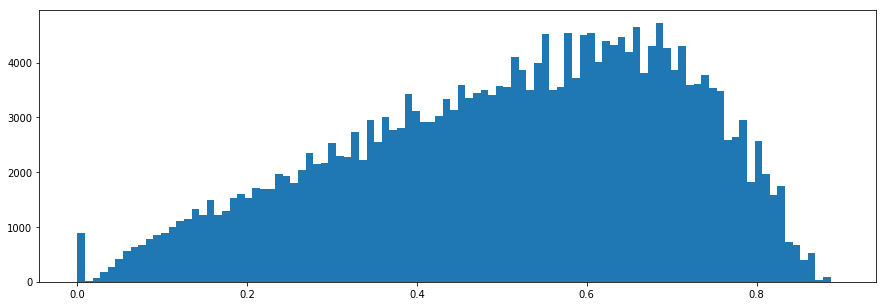

In [35]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.hist(df_app['EXT_SOURCE_3'].dropna().values.tolist(), bins = 100)

In [36]:
df_app['EXT_SOURCE_3'].median()

0.5352762504724826

The distribution of this field shows that it is negatively skewed. THe mode of the distribution comprisees of roughly 5000 ovservations,  replacing the ~61,000 observations with the median would mean that this distribution would be undershadowed with a mode standing at 0.53, thus overfitting the distribution with the imputed value.

The similar exercise was repeated for 'AMT_REQ_CREDIT_BUREAU_YEAR' which comprised of 13.5% missing values (i.e. ~42,000 observations)

In [37]:
df_app['AMT_REQ_CREDIT_BUREAU_YEAR'].value_counts()

0.0     71801
1.0     63405
2.0     50192
3.0     33628
4.0     20714
5.0     12052
6.0      6967
7.0      3869
8.0      2127
9.0      1096
11.0       31
12.0       30
10.0       22
13.0       19
14.0       10
17.0        7
15.0        6
19.0        4
18.0        4
16.0        3
21.0        1
23.0        1
25.0        1
20.0        1
22.0        1
Name: AMT_REQ_CREDIT_BUREAU_YEAR, dtype: int64

(array([7.1801e+04, 6.3405e+04, 5.0192e+04, 3.3628e+04, 2.0714e+04,
        0.0000e+00, 1.2052e+04, 6.9670e+03, 3.8690e+03, 2.1270e+03,
        1.0960e+03, 0.0000e+00, 2.2000e+01, 3.1000e+01, 3.0000e+01,
        1.9000e+01, 1.0000e+01, 0.0000e+00, 6.0000e+00, 3.0000e+00,
        7.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.        ,  0.83333333,  1.66666667,  2.5       ,  3.33333333,
         4.16666667,  5.        ,  5.83333333,  6.66666667,  7.5       ,
         8.33333333,  9.16666667, 10.        , 10.83333333, 11.66666667,
        12.5       , 13.33333333, 14.16666667, 15.        , 15.83333333,
        16.66666667, 17.5       , 18.33333333, 19.16666667, 20.        ,
        20.83333333, 21.66666667, 22.5       , 23.33333333, 24.16666667,
        25.        ]),
 <a list of 30 Patch objects>)

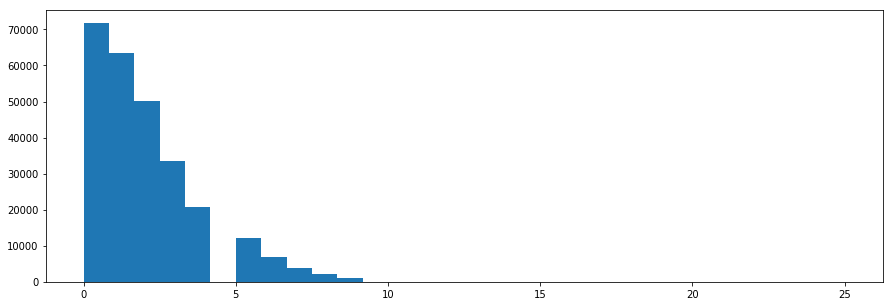

In [38]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.hist(df_app['AMT_REQ_CREDIT_BUREAU_YEAR'].dropna().values.tolist(), bins = 30)

In [39]:
df_app['AMT_REQ_CREDIT_BUREAU_YEAR'].mode()

0    0.0
dtype: float64

Here the distribution resembles to decreaasing exponential graph. Replacing the missing values with the mode (i.e. 0) won't affect the distribution and it will remain to be a negative exponential distribution. Hence we decided to keep the threshold of 15%. Fields exceeding proportion of missing values exceeeding this threshold will be removed from the dataset. Those having missing values within the range of 1% - 15% of missing values, will be imputed by mode. THe reason for choosing the mode is because,  all fields falling within this range represent number of enquires which are discrete values. Remaining fields with less then 1% of missing values are removed from the dataset as removing them won't put in a huge impact on the behaviors within the dataset and we would want to avoid imputation as much as poossible.

#### Treatment of threshold bucket 1

In [40]:
cols_remove = missing_per[missing_per > 0.15].index.tolist()

In [41]:
len(cols_remove)

23

In [42]:
df_app = df_app.drop(cols_remove, axis = 1)
df_app.shape

(307511, 71)

#### Treatment of threshold bucket 2

In [43]:
cols_impute = missing_per[(missing_per > 0.01) & (missing_per <= 0.15)].index.tolist()

In [44]:
len(cols_impute)

6

In [52]:
for col in cols_impute:
    df_app[col] = df_app[col].fillna(df_app[col].mode().values[0])

#### Treatment of threshold bucket 3

In [54]:
df_app = df_app.dropna()
df_app.shape

(304531, 71)

After removing 23 columns, imputing 6 attributes, and removing 3,000 rows we are left with 71 attributes and roughly 304,531 rows. A similar treatment will be applied to the Previous application dataset as well.

**previous_application.csv** contains information about the client’s previous loan data. It contains the data whether the previous application had been Approved, Cancelled, Refused or Unused offer. 

### Importing the previous loan data

In [55]:
df_prev = pd.read_csv('previous_application.csv', low_memory = False)
df_prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df_prev.shape

(1670214, 37)

This dataset consists of 1.6 million observations and 37 columns. Given that loan request can have multiple loan requests earlier, hence a SK_ID_CURR can have multiple SK_ID_PREV records. Contrary to the earlier dataset, there are existss no multiple aggregates of a single attribute. Hence there is no need of removing  the columns initially.

### Dealing with missing values within the application related data

The details of attributes with missing values is as follows:

In [21]:
print('Columns with missing values\n')
    
missing_sum = df_prev.isnull().sum()
missing_sum = missing_sum[missing_sum > 0]
print(missing_sum.shape)
missing_sum.sort_values(ascending = False)

Columns with missing values

(16,)


RATE_INTEREST_PRIVILEGED     1664263
RATE_INTEREST_PRIMARY        1664263
RATE_DOWN_PAYMENT             895844
AMT_DOWN_PAYMENT              895844
NAME_TYPE_SUITE               820405
NFLAG_INSURED_ON_APPROVAL     673065
DAYS_TERMINATION              673065
DAYS_LAST_DUE                 673065
DAYS_LAST_DUE_1ST_VERSION     673065
DAYS_FIRST_DUE                673065
DAYS_FIRST_DRAWING            673065
AMT_GOODS_PRICE               385515
AMT_ANNUITY                   372235
CNT_PAYMENT                   372230
PRODUCT_COMBINATION              346
AMT_CREDIT                         1
dtype: int64

In [22]:
missing_per = missing_sum / df_prev.shape[0]
missing_per.sort_values(ascending = False)

RATE_INTEREST_PRIVILEGED     9.964370e-01
RATE_INTEREST_PRIMARY        9.964370e-01
RATE_DOWN_PAYMENT            5.363648e-01
AMT_DOWN_PAYMENT             5.363648e-01
NAME_TYPE_SUITE              4.911975e-01
NFLAG_INSURED_ON_APPROVAL    4.029813e-01
DAYS_TERMINATION             4.029813e-01
DAYS_LAST_DUE                4.029813e-01
DAYS_LAST_DUE_1ST_VERSION    4.029813e-01
DAYS_FIRST_DUE               4.029813e-01
DAYS_FIRST_DRAWING           4.029813e-01
AMT_GOODS_PRICE              2.308177e-01
AMT_ANNUITY                  2.228667e-01
CNT_PAYMENT                  2.228637e-01
PRODUCT_COMBINATION          2.071591e-04
AMT_CREDIT                   5.987257e-07
dtype: float64

Out of the 37 attributes, 16 attributes have missing values. THe missing proportion is as high as 99.6% of the values, and as low as 0.000006%. As per the threshold defined earlier, we are going to divide these attributes in 3 buckets with some removed, some imputed, and some leading to the dataset be reduced.

#### Treatment of threshold bucket 1

In [23]:
cols_remove = missing_per[missing_per > 0.1].index.tolist()
len(cols_remove)

14

In [24]:
df_prev = df_prev.drop(cols_remove, axis = 1)
df_prev.shape

(1670214, 23)

#### Treatment of threshold bucket 2

In [25]:
cols_impute = missing_per[(missing_per > 0.01) & (missing_per <= 0.1)].index.tolist()
len(cols_impute)

0

#### Treatment of threshold bucket 3

In [26]:
df_prev = df_prev.dropna()
df_prev.shape

(1669867, 23)

In [27]:
common_fields = list(set(df_prev.columns).intersection(df_app.columns))
common_fields.remove('SK_ID_CURR')
print(common_fields)

['AMT_CREDIT', 'WEEKDAY_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE', 'HOUR_APPR_PROCESS_START']


In [28]:
for col in common_fields:
    df_prev.rename(columns={col: '%s_PREV'%col}, inplace=True)

In [29]:
for col in df_prev.columns:
    print(col, df_prev[col].dtype.name, df_prev[col].nunique())

('SK_ID_PREV', 'int64', 1669867)
('SK_ID_CURR', 'int64', 338857)
('NAME_CONTRACT_TYPE_PREV', 'object', 3)
('AMT_APPLICATION', 'float64', 93885)
('AMT_CREDIT_PREV', 'float64', 86803)
('WEEKDAY_APPR_PROCESS_START_PREV', 'object', 7)
('HOUR_APPR_PROCESS_START_PREV', 'int64', 24)
('FLAG_LAST_APPL_PER_CONTRACT', 'object', 2)
('NFLAG_LAST_APPL_IN_DAY', 'int64', 2)
('NAME_CASH_LOAN_PURPOSE', 'object', 25)
('NAME_CONTRACT_STATUS', 'object', 4)
('DAYS_DECISION', 'int64', 2922)
('NAME_PAYMENT_TYPE', 'object', 4)
('CODE_REJECT_REASON', 'object', 9)
('NAME_CLIENT_TYPE', 'object', 4)
('NAME_GOODS_CATEGORY', 'object', 28)
('NAME_PORTFOLIO', 'object', 5)
('NAME_PRODUCT_TYPE', 'object', 3)
('CHANNEL_TYPE', 'object', 8)
('SELLERPLACE_AREA', 'int64', 2097)
('NAME_SELLER_INDUSTRY', 'object', 11)
('NAME_YIELD_GROUP', 'object', 5)
('PRODUCT_COMBINATION', 'object', 17)


In [30]:
disc_cols = []
cont_cols  = []

for col in df_prev.columns:
    if col not in ['SK_ID_CURR', 'SK_ID_PREV']:
    
        if df_prev[col].nunique() < 50:
            disc_cols.append(col)
        else:
            cont_cols.append(col)

print('Discrete columns: %d'%len(disc_cols))
print('Continuous columns: %d'%len(cont_cols))

Discrete columns: 17
Continuous columns: 4


In [31]:
eval_list = []
eval_text = "df_prev.groupby('SK_ID_CURR').agg({"

for col in df_prev.columns:
    if col in disc_cols:
#         eval_list.append("'%s' : lambda x: stats.mode(x)[0]"%col)
        continue
    elif col in cont_cols:
        eval_list.append("'%s' : 'median'"%col)

eval_text += ",".join(eval_list)
eval_text += "})"

df_pagg = eval(eval_text)

In [32]:
df_pagg.head()

,AMT_APPLICATION,DAYS_DECISION,AMT_CREDIT_PREV,SELLERPLACE_AREA
SK_ID_CURR,,,,
100001,24835.50,-1740.0,23787.00,23.0
100002,179055.00,-606.0,179055.00,500.0
100003,337500.00,-828.0,348637.50,200.0
100004,24282.00,-815.0,20106.00,30.0
100005,22308.75,-536.0,20076.75,18.0


In [33]:
df_pagg = df_pagg.reset_index()

In [34]:
df_app = df_app.merge(df_pagg, how='left')

In [35]:
df_app.shape

(304531, 69)

In [36]:
print('Columns with missing values\n')
    
missing_sum = df_app.isnull().sum()
missing_sum = missing_sum[missing_sum > 0]
print(missing_sum.shape)
missing_sum.sort_values(ascending = False)

Columns with missing values

(4,)


SELLERPLACE_AREA    15624
AMT_CREDIT_PREV     15624
DAYS_DECISION       15624
AMT_APPLICATION     15624
dtype: int64

In [37]:
missing_per = missing_sum / df_app.shape[0]
missing_per.sort_values(ascending = False)

SELLERPLACE_AREA    0.051305
AMT_CREDIT_PREV     0.051305
DAYS_DECISION       0.051305
AMT_APPLICATION     0.051305
dtype: float64

In [38]:
df_app = df_app.fillna(df_app.median())

In [39]:
missing_sum = df_app.isnull().sum()
missing_sum = missing_sum[missing_sum > 0]
missing_per = missing_sum / df_app.shape[0]
missing_per.sort_values(ascending = False)

Series([], dtype: float64)

In [40]:
for col in df_app.columns:
    print(col, df_app[col].dtype.name, df_app[col].nunique())

('SK_ID_CURR', 'int64', 304531)
('TARGET', 'int64', 2)
('NAME_CONTRACT_TYPE', 'object', 2)
('CODE_GENDER', 'object', 3)
('FLAG_OWN_CAR', 'object', 2)
('FLAG_OWN_REALTY', 'object', 2)
('CNT_CHILDREN', 'int64', 15)
('AMT_INCOME_TOTAL', 'float64', 2512)
('AMT_CREDIT', 'float64', 5585)
('AMT_ANNUITY', 'float64', 13652)
('AMT_GOODS_PRICE', 'float64', 985)
('NAME_TYPE_SUITE', 'object', 7)
('NAME_INCOME_TYPE', 'object', 8)
('NAME_EDUCATION_TYPE', 'object', 5)
('NAME_FAMILY_STATUS', 'object', 5)
('NAME_HOUSING_TYPE', 'object', 6)
('REGION_POPULATION_RELATIVE', 'float64', 81)
('DAYS_BIRTH', 'int64', 17458)
('DAYS_EMPLOYED', 'int64', 12556)
('DAYS_REGISTRATION', 'float64', 15678)
('DAYS_ID_PUBLISH', 'int64', 6167)
('FLAG_MOBIL', 'int64', 1)
('FLAG_EMP_PHONE', 'int64', 2)
('FLAG_WORK_PHONE', 'int64', 2)
('FLAG_CONT_MOBILE', 'int64', 2)
('FLAG_PHONE', 'int64', 2)
('FLAG_EMAIL', 'int64', 2)
('CNT_FAM_MEMBERS', 'float64', 17)
('REGION_RATING_CLIENT', 'int64', 3)
('REGION_RATING_CLIENT_W_CITY', 'int6

In [41]:
disc_cols = []
cont_cols  = []

for col in df_app.columns:
    if col != 'SK_ID_CURR':
    
        if df_app[col].nunique() < 20 or df_app[col].dtype.name == 'object':
            disc_cols.append(col)
        else:
            cont_cols.append(col)

print('Discrete columns: %d'%len(disc_cols))
print('Continuous columns: %d'%len(cont_cols))

Discrete columns: 50
Continuous columns: 18


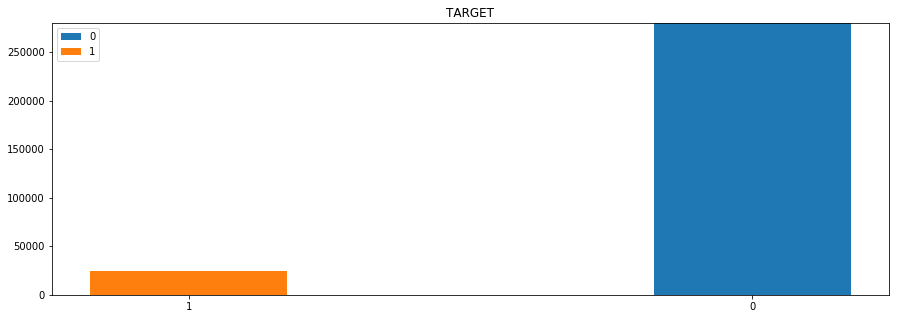

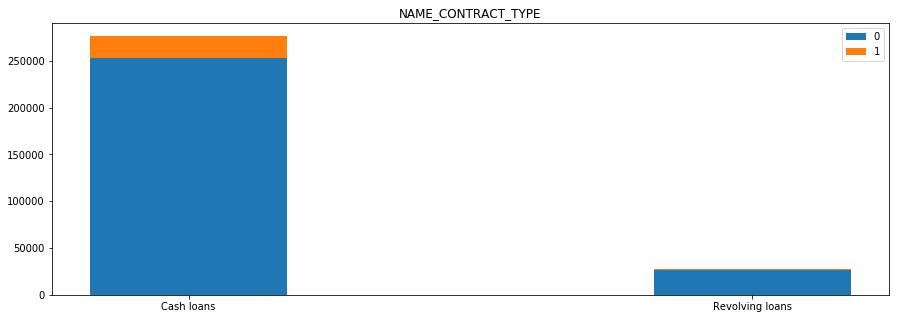

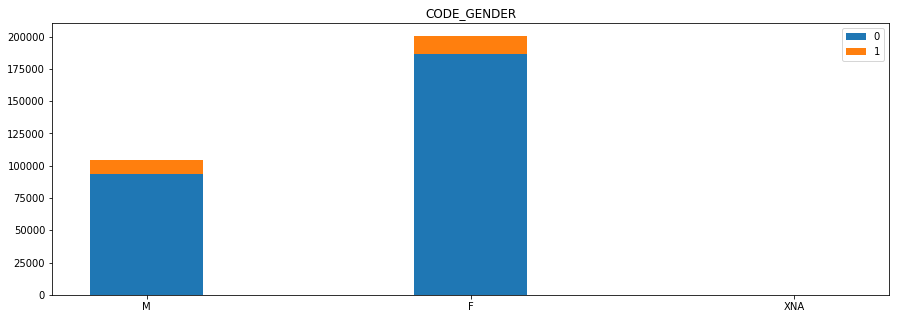

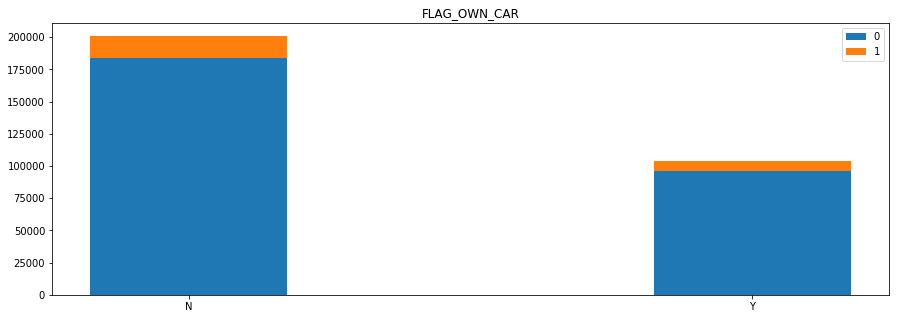

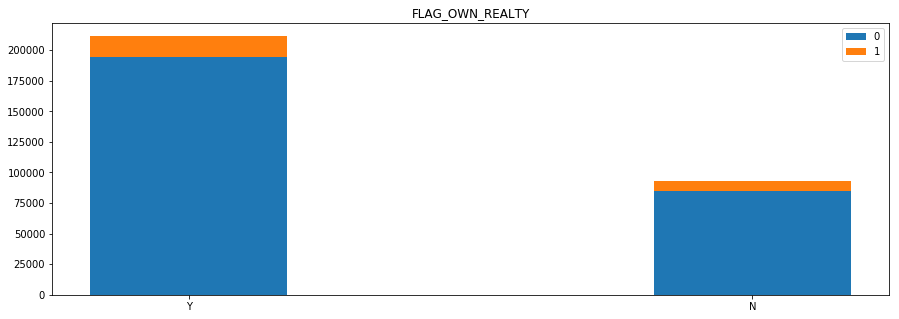

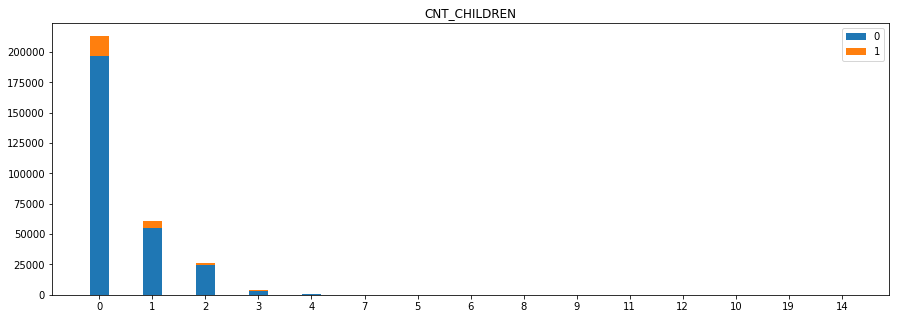

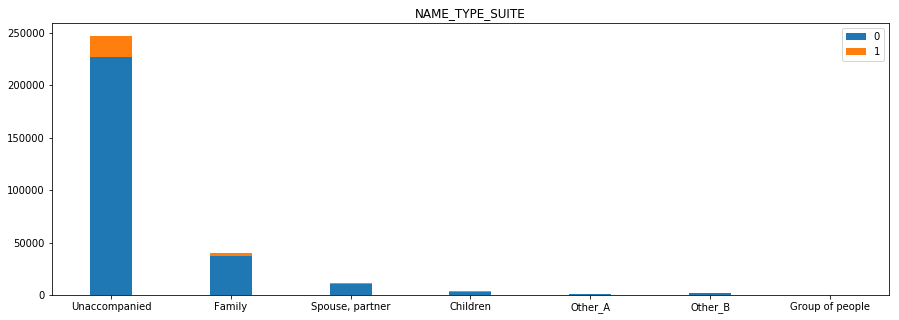

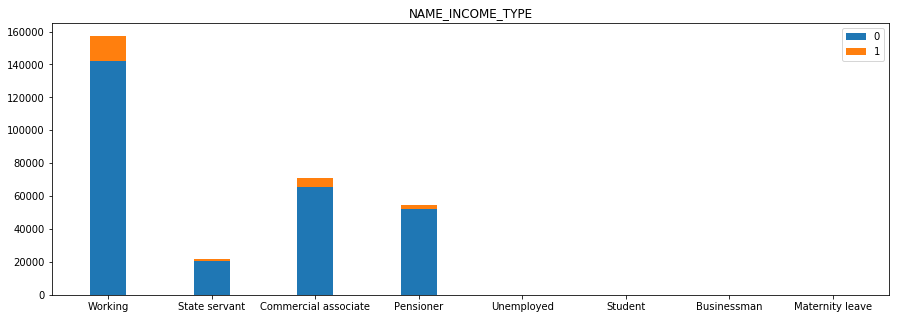

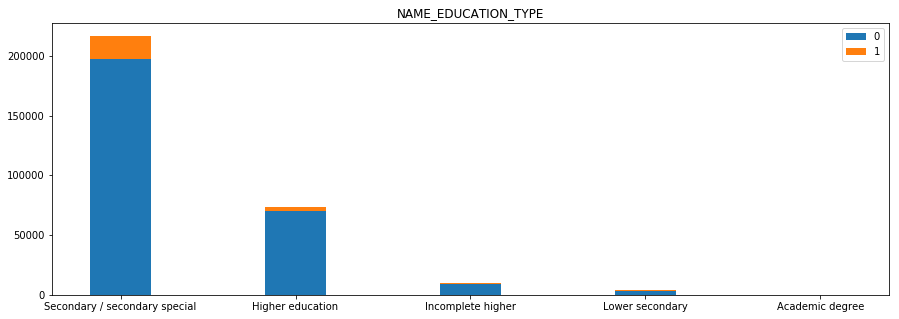

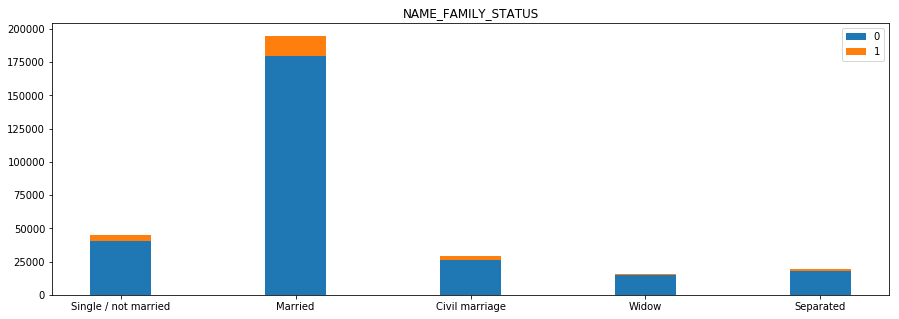

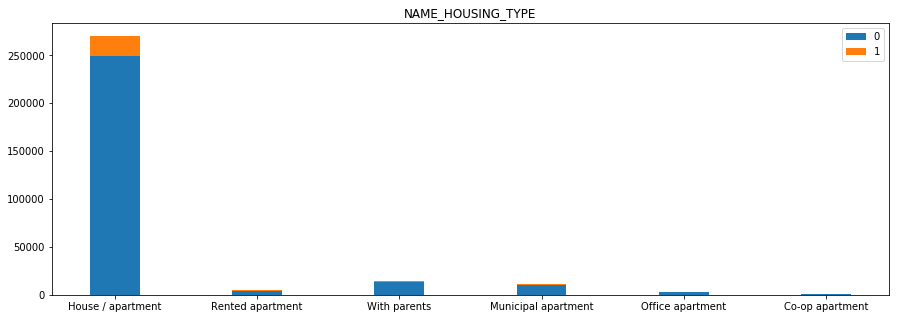

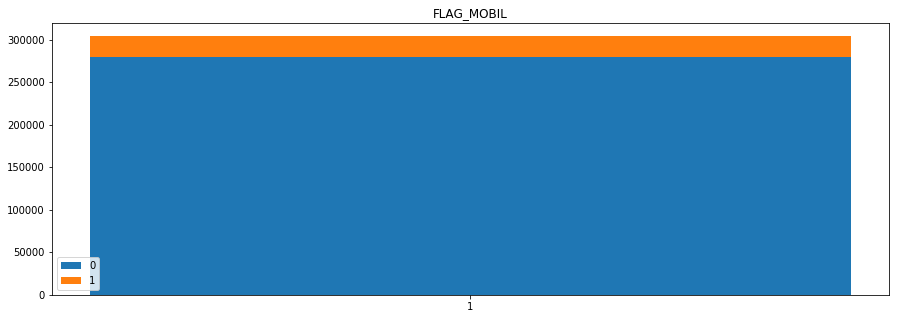

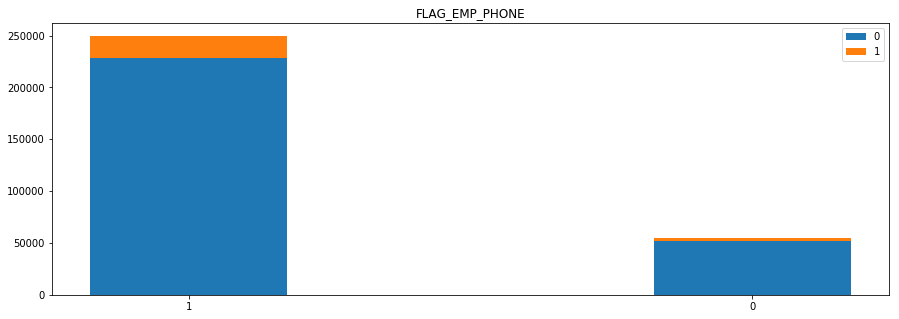

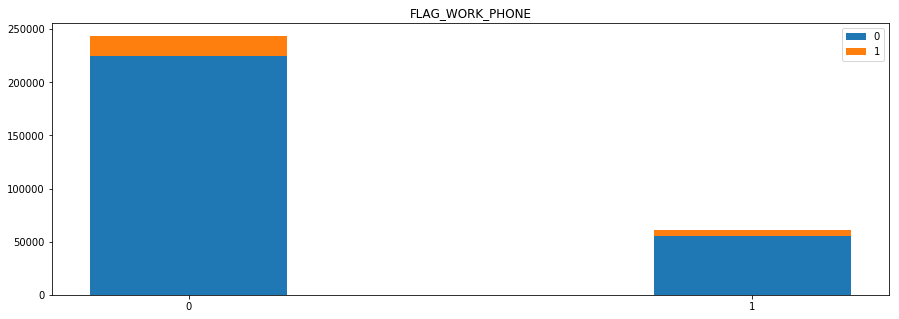

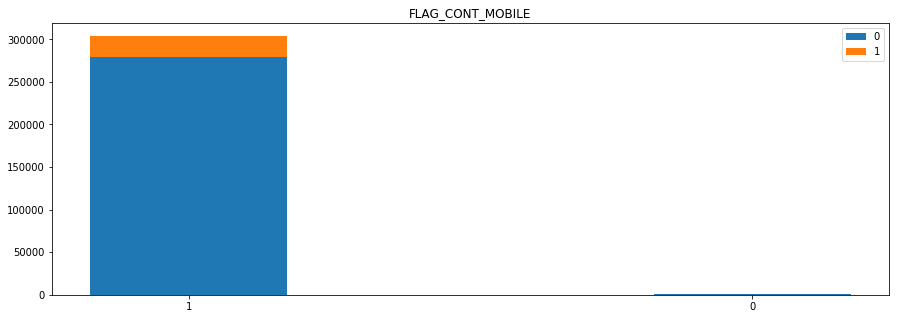

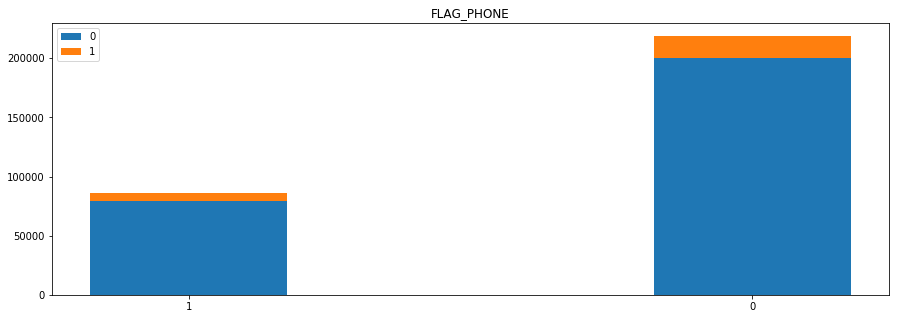

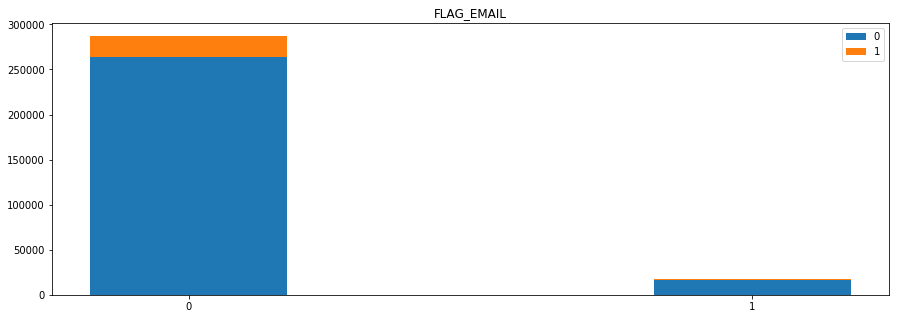

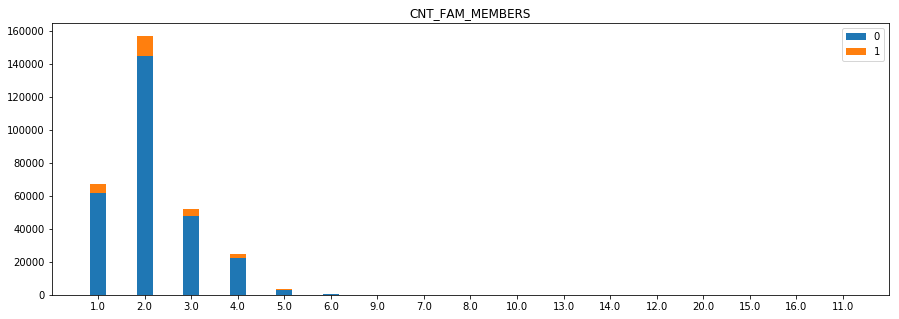

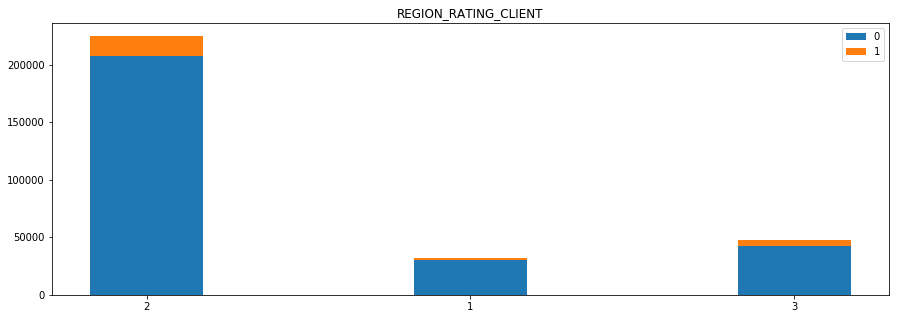

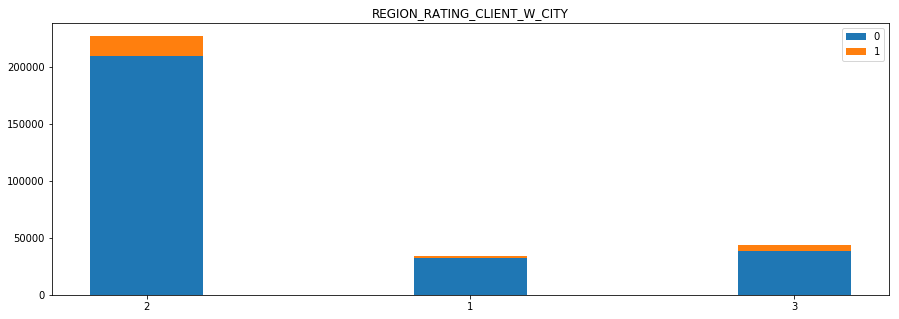

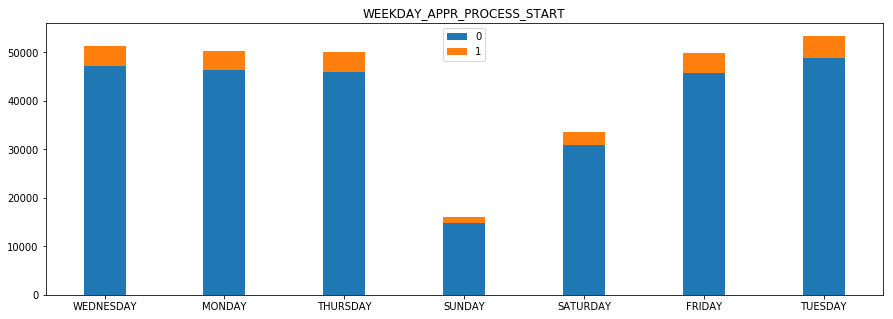

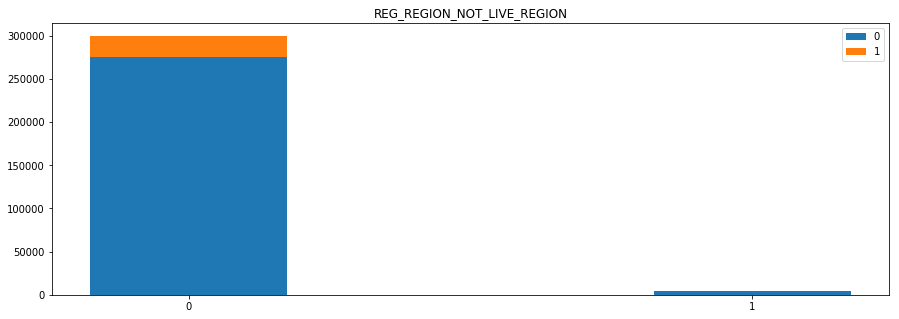

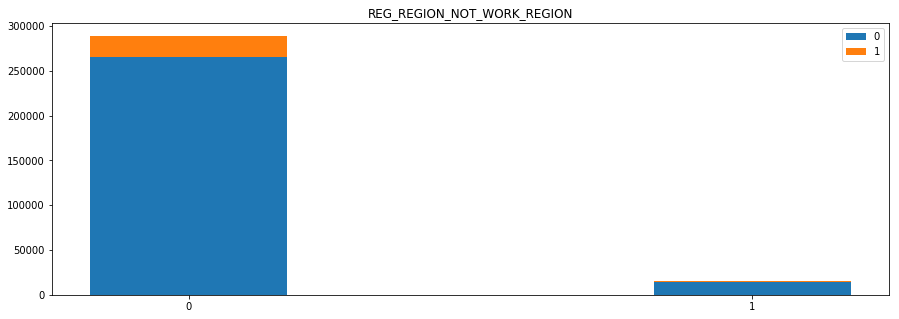

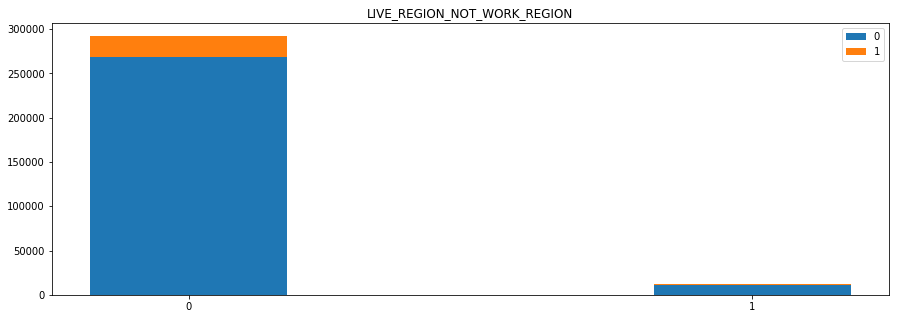

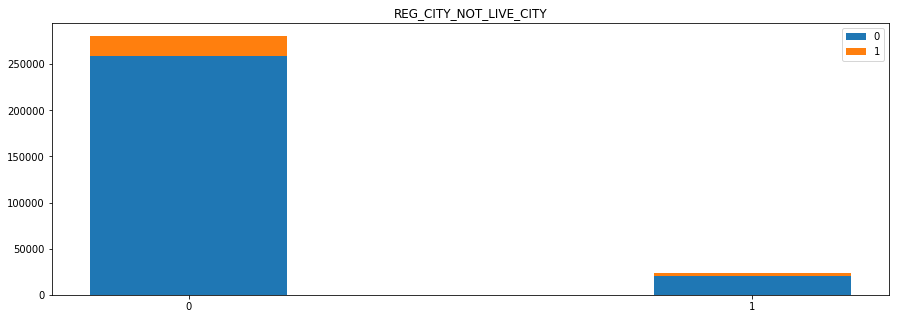

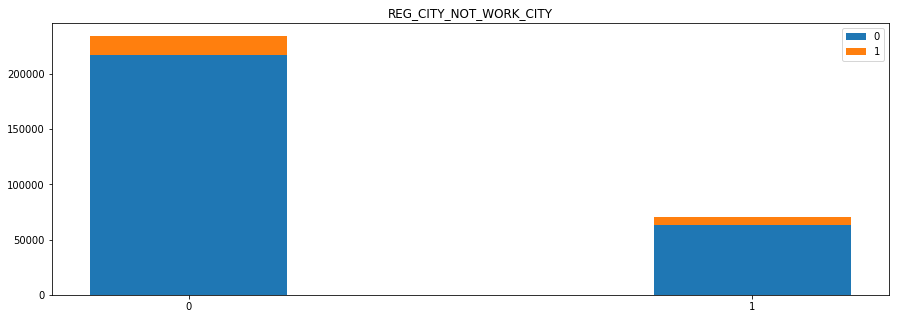

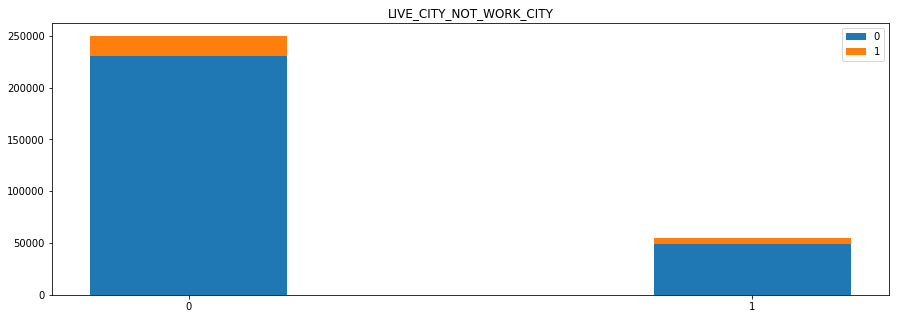

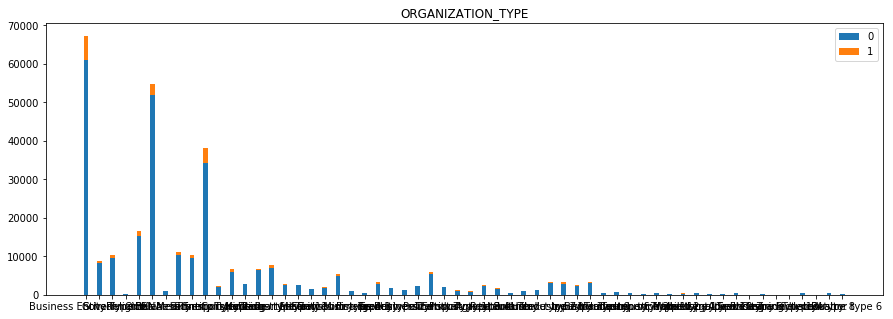

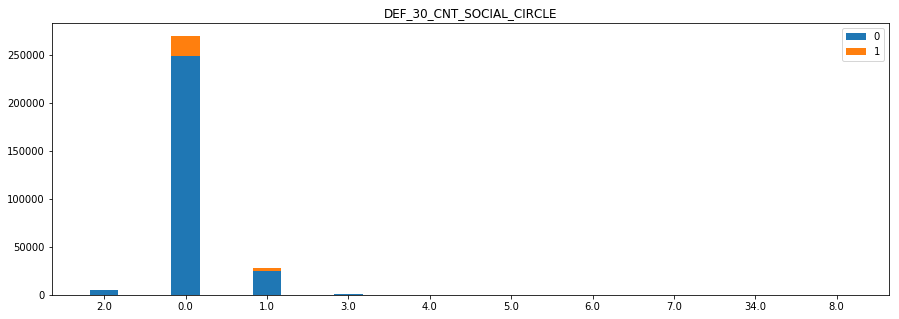

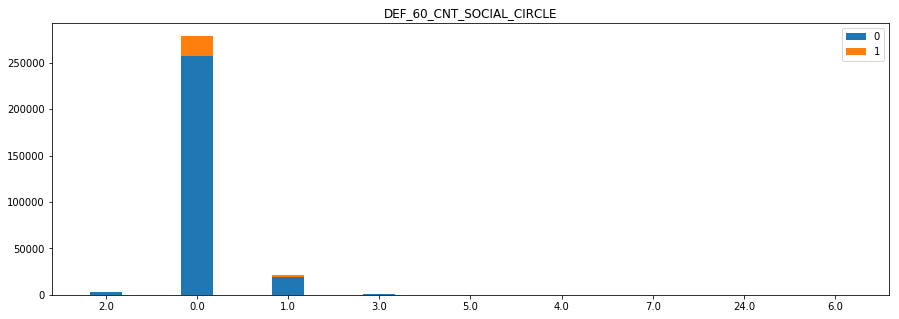

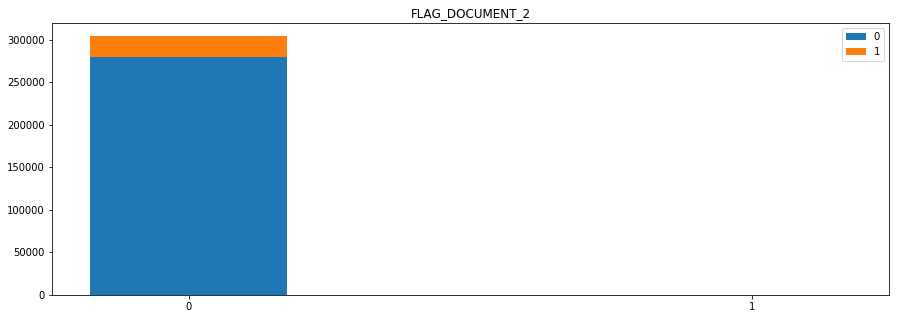

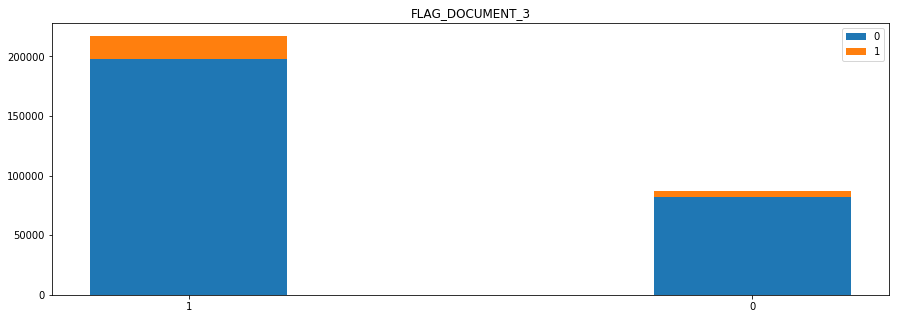

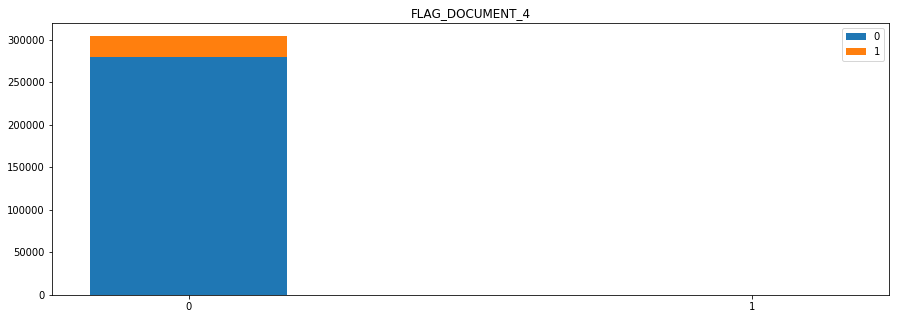

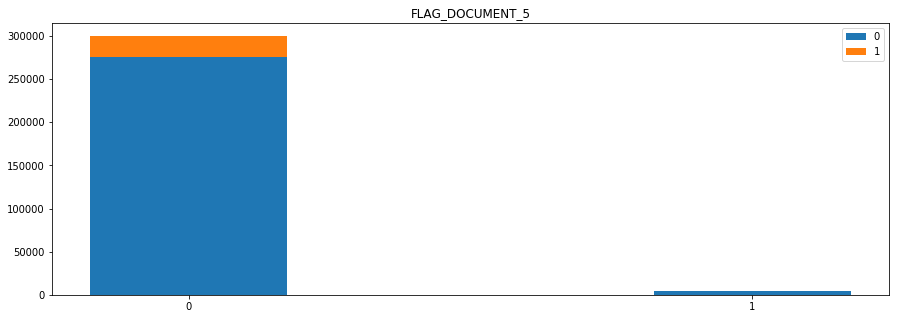

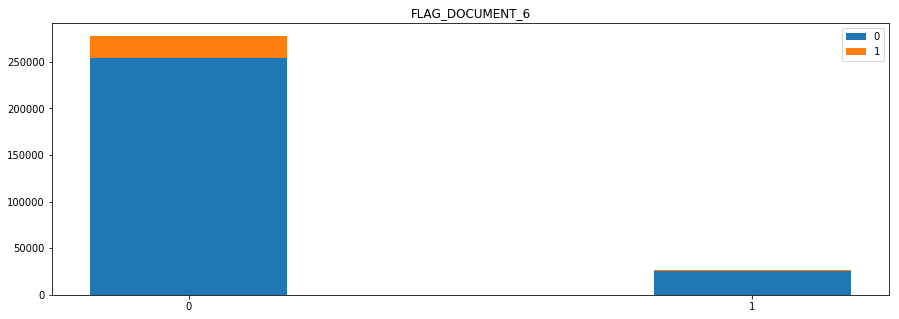

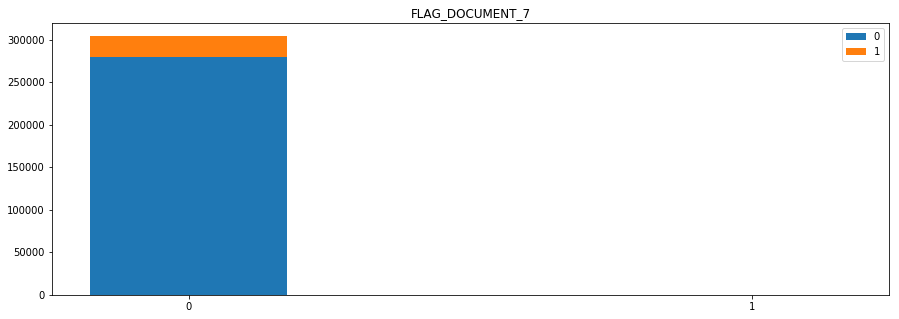

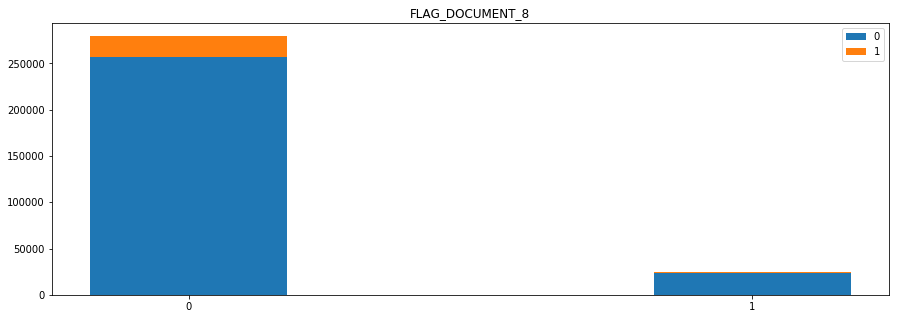

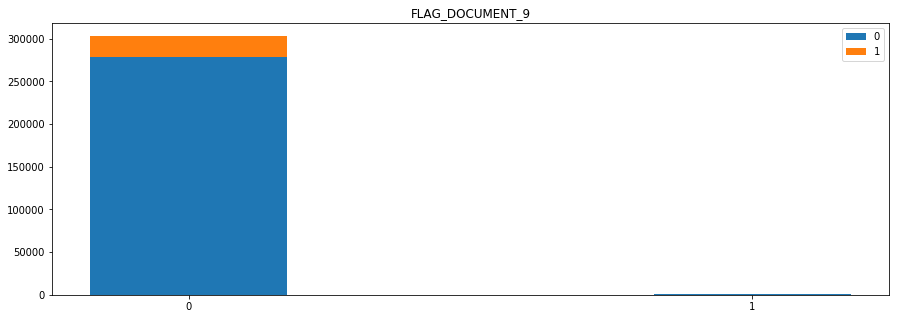

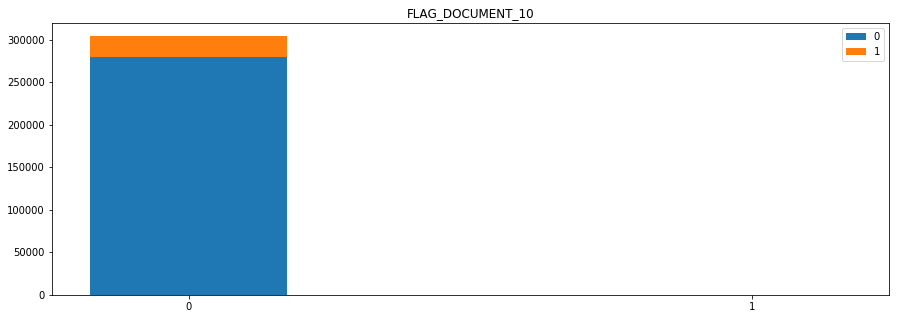

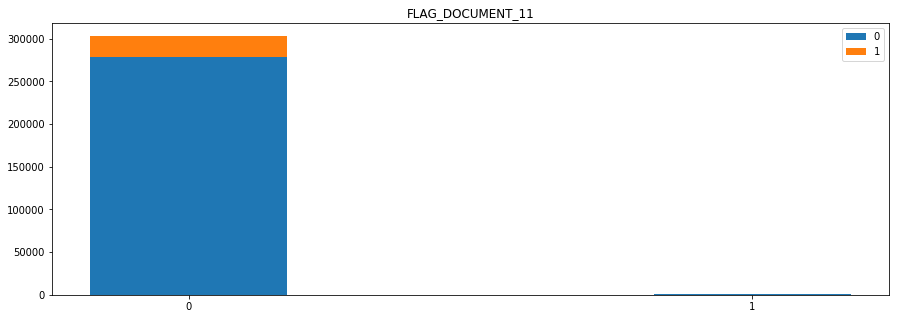

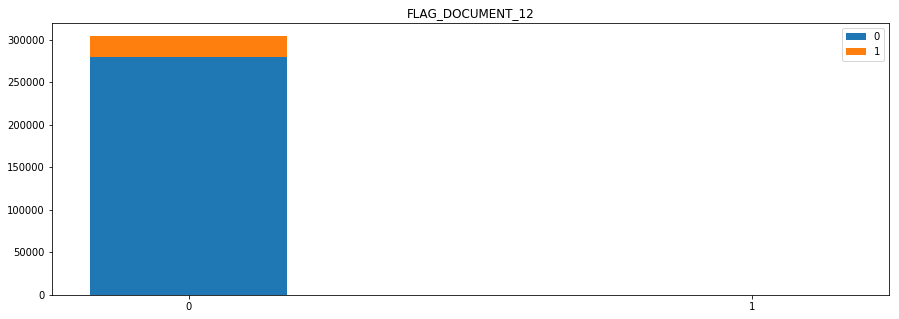

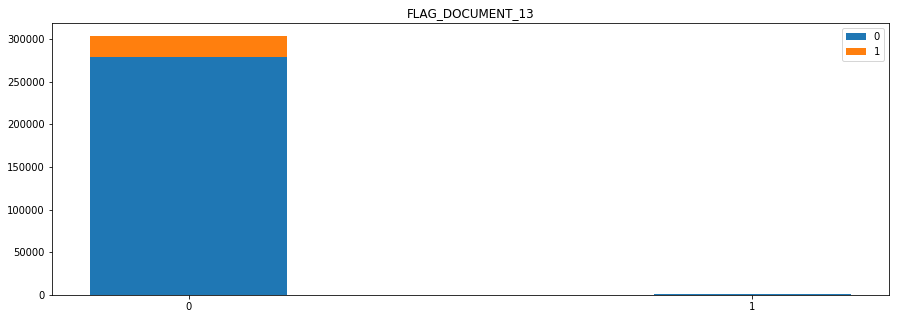

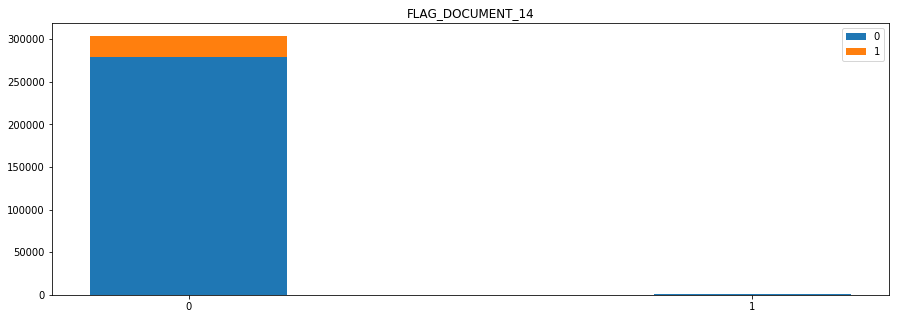

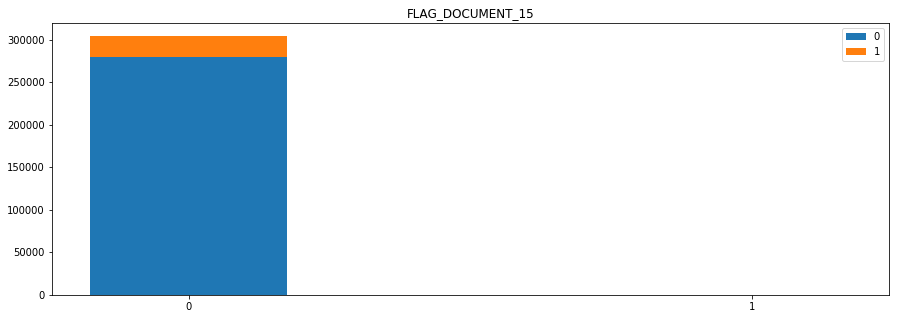

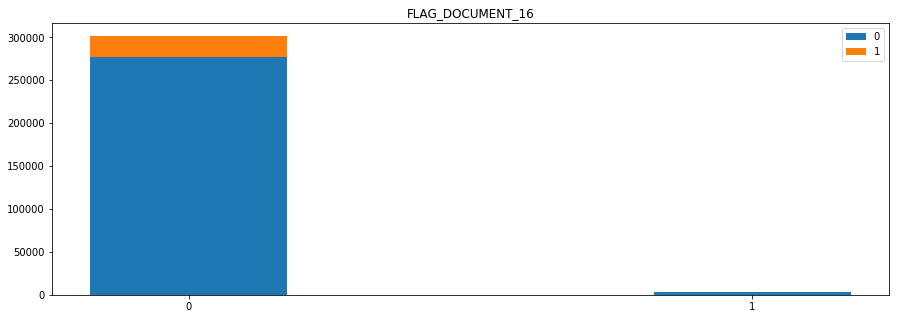

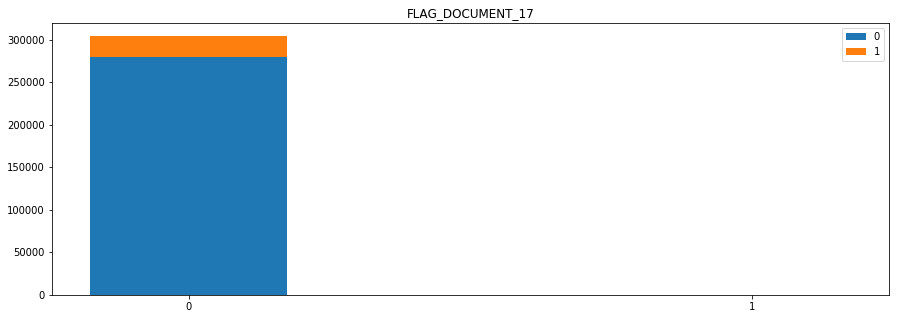

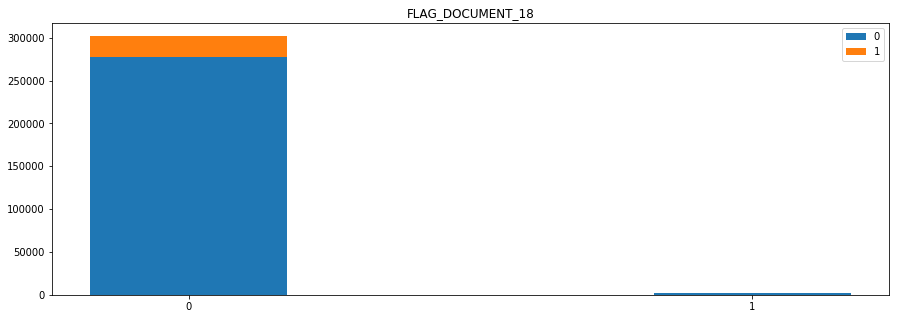

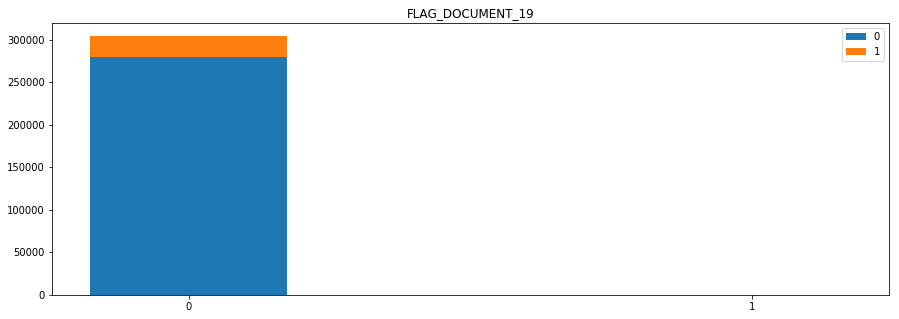

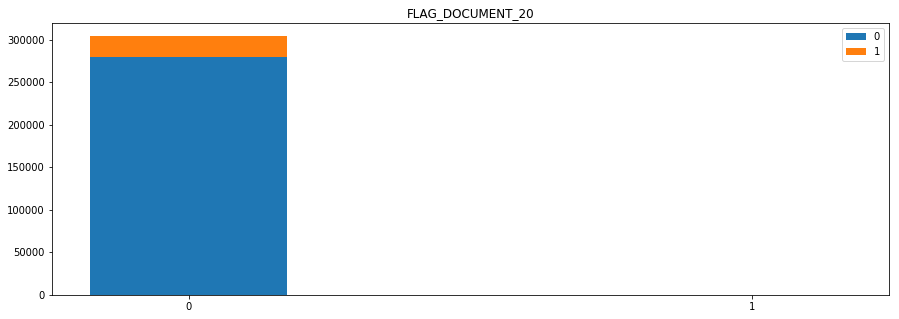

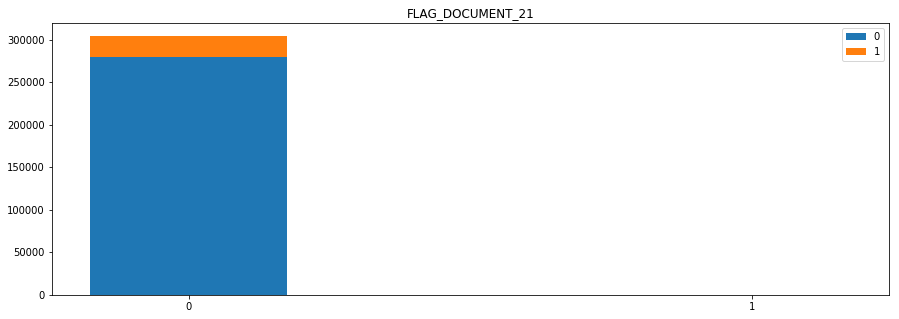

In [42]:
plt.rcParams['figure.figsize'] = [15, 5]

for col in disc_cols:
    
    width = 0.35
    dist_values = df_app[col].unique().tolist()
    ind = range(len(dist_values))
    
    target_1_obj = df_app[df_app['TARGET'] == 1][col].value_counts()
    target_1_values = [target_1_obj.get(d,  0) for d in dist_values]
    
    target_0_obj = df_app[df_app['TARGET'] == 0][col].value_counts()
    target_0_values = [target_0_obj.get(d, 0) for d in dist_values]

    p1 = plt.bar(ind, target_0_values, width)
    p2 = plt.bar(ind, target_1_values, width,bottom=target_0_values)

    plt.xticks(ind, tuple(dist_values))
    plt.legend((p1[0], p2[0]), (0, 1))
    plt.title(col)
    plt.show()

In [43]:
for col in disc_cols:
    print(df_app[col].value_counts(normalize=True) * 100)

0    91.900004
1     8.099996
Name: TARGET, dtype: float64
Cash loans         90.83246
Revolving loans     9.16754
Name: NAME_CONTRACT_TYPE, dtype: float64
F      65.833035
M      34.165651
XNA     0.001313
Name: CODE_GENDER, dtype: float64
N    65.973579
Y    34.026421
Name: FLAG_OWN_CAR, dtype: float64
Y    69.497358
N    30.502642
Name: FLAG_OWN_REALTY, dtype: float64
0     70.034578
1     19.873182
2      8.702562
3      1.208416
4      0.139887
5      0.027583
6      0.006896
7      0.002299
14     0.000985
19     0.000657
12     0.000657
10     0.000657
9      0.000657
8      0.000657
11     0.000328
Name: CNT_CHILDREN, dtype: float64
Unaccompanied      81.145105
Family             13.124772
Spouse, partner     3.714893
Children            1.066886
Other_B             0.576953
Other_A             0.283715
Group of people     0.087676
Name: NAME_TYPE_SUITE, dtype: float64
Working                 51.666661
Commercial associate    23.246894
Pensioner               18.008347
State se

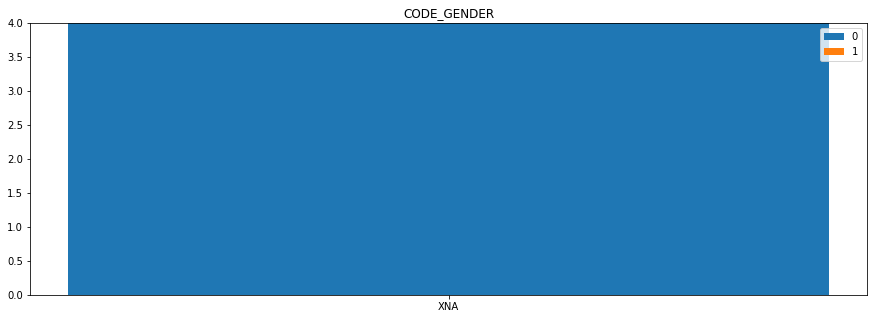

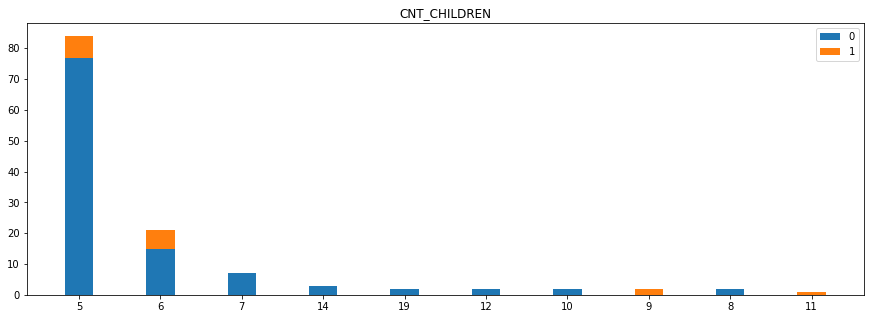

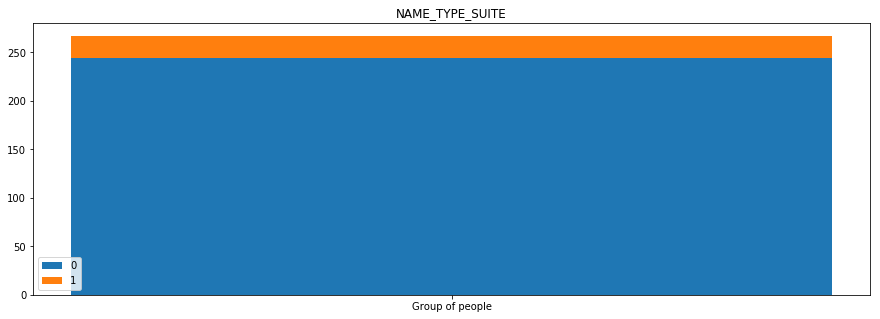

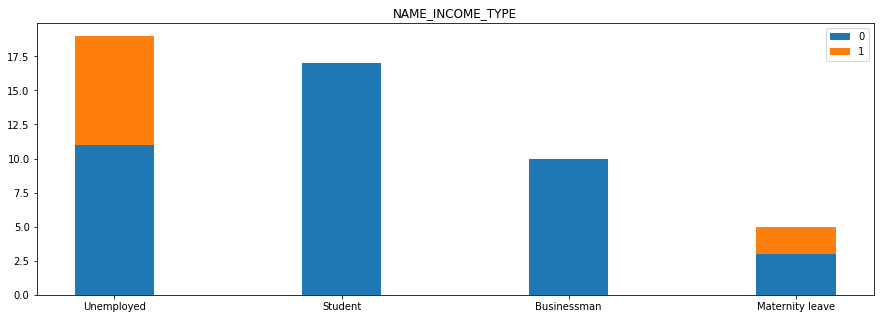

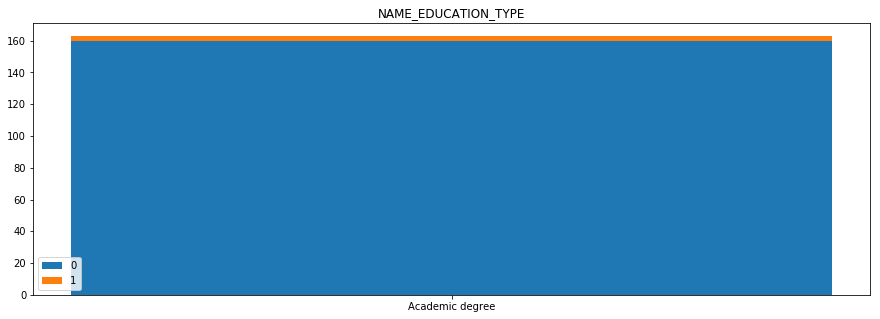

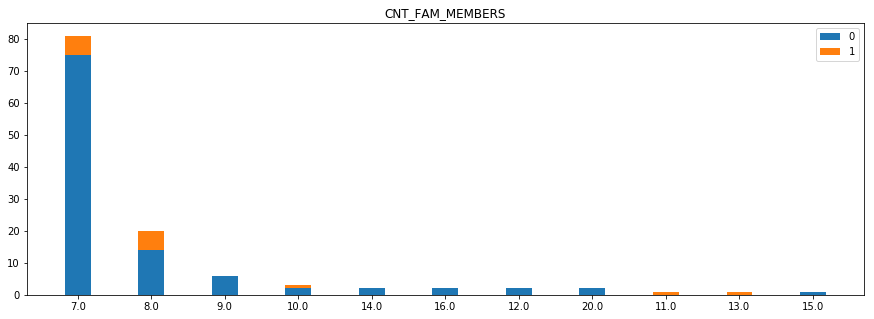

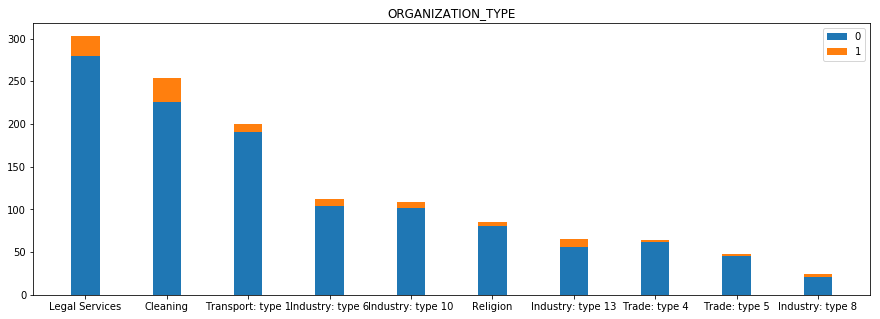

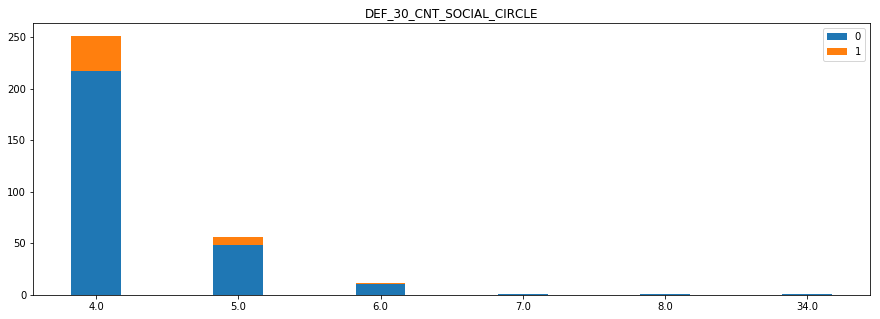

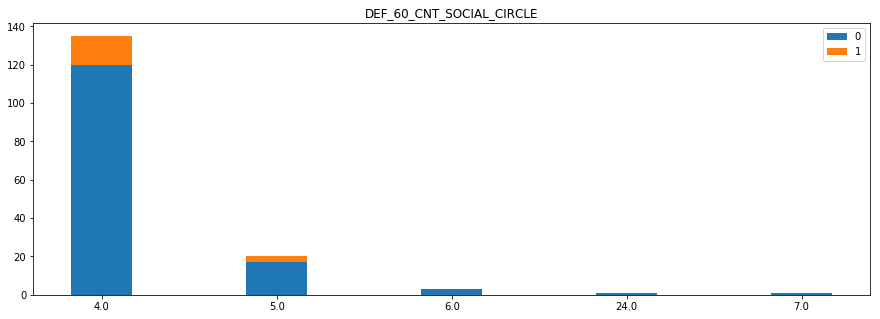

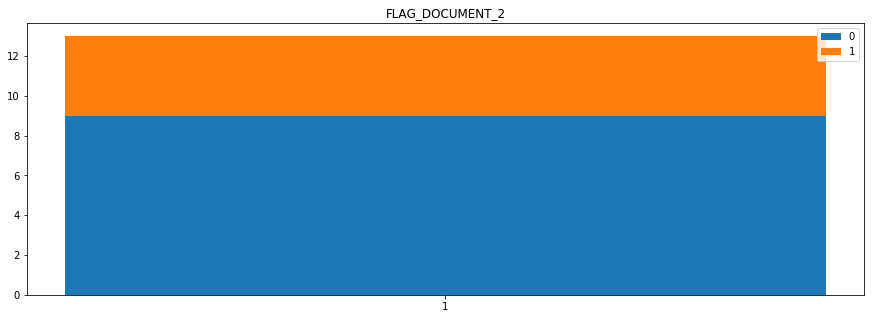

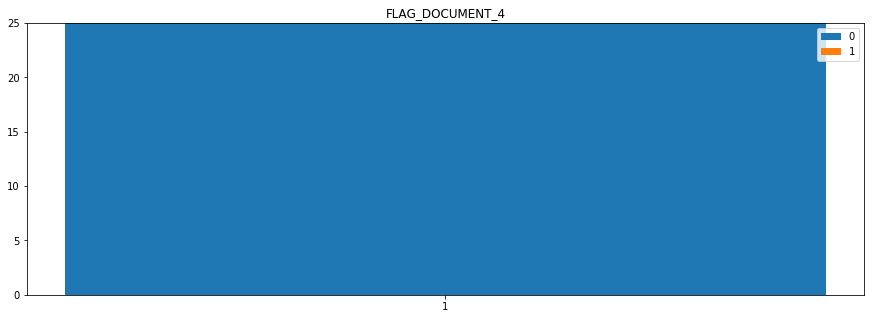

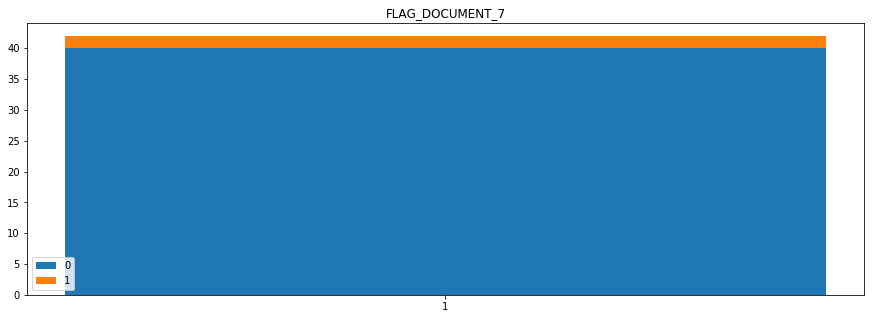

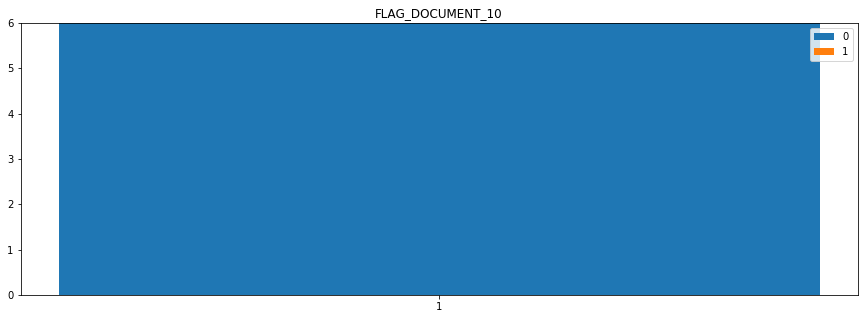

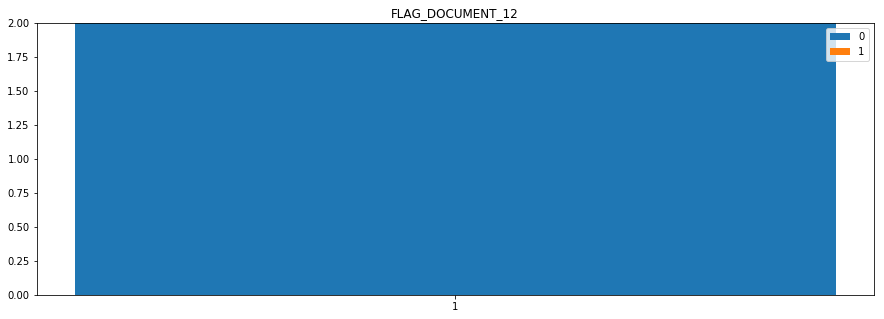

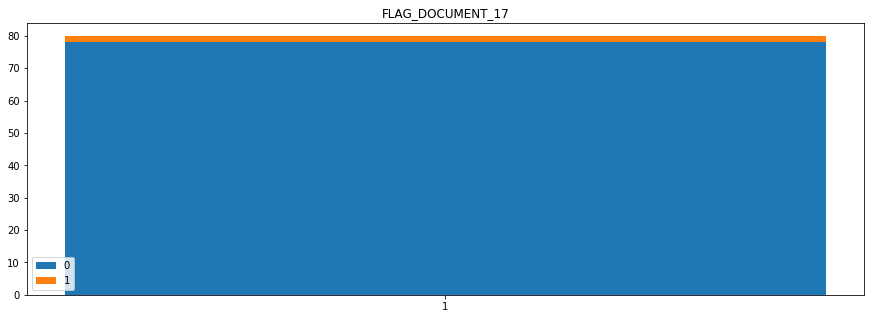

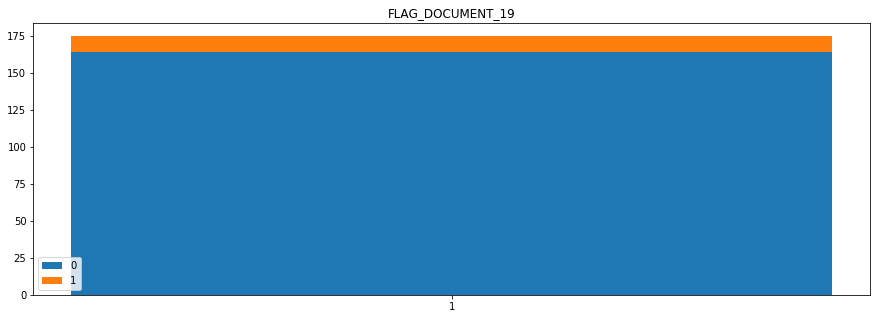

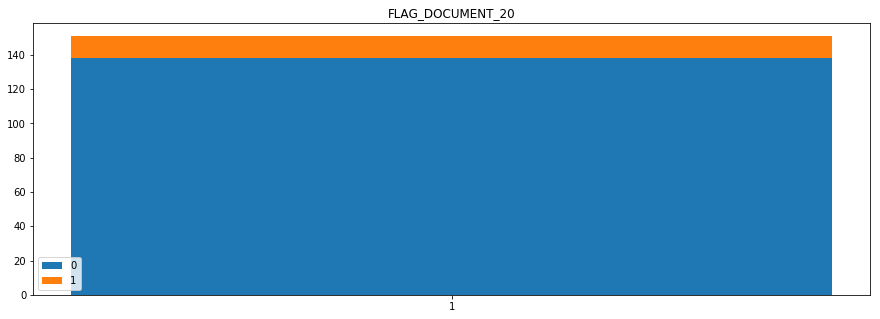

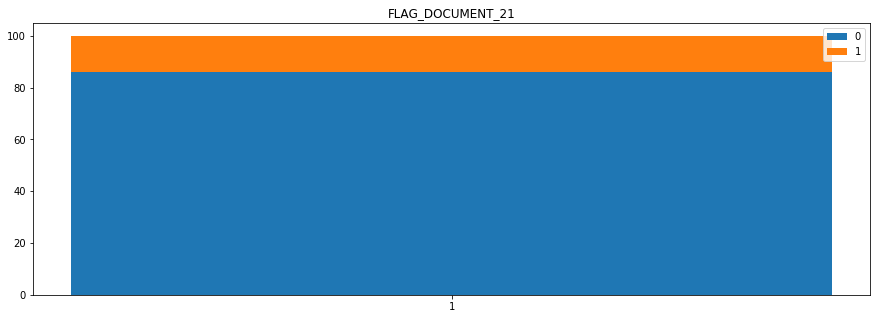

In [44]:
for col in disc_cols:
    per = df_app[col].value_counts(normalize=True) * 100
    dist_values = per[per<0.1].index.tolist()

    if dist_values:
        width = 0.35
        ind = range(len(dist_values))

        target_1_obj = df_app[df_app['TARGET'] == 1][col].value_counts()
        target_1_values = [target_1_obj.get(d,  0) for d in dist_values]

        target_0_obj = df_app[df_app['TARGET'] == 0][col].value_counts()
        target_0_values = [target_0_obj.get(d, 0) for d in dist_values]

        p1 = plt.bar(ind, target_0_values, width)
        p2 = plt.bar(ind, target_1_values, width,bottom=target_0_values)

        plt.xticks(ind, tuple(dist_values))
        plt.legend((p1[0], p2[0]), (0, 1))
        plt.title(col)
        plt.show()

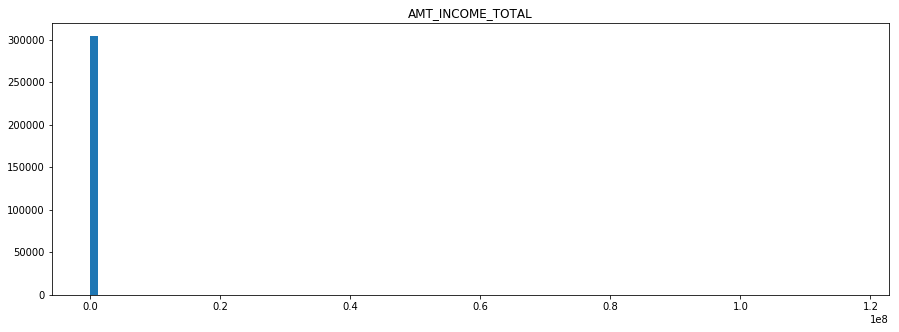

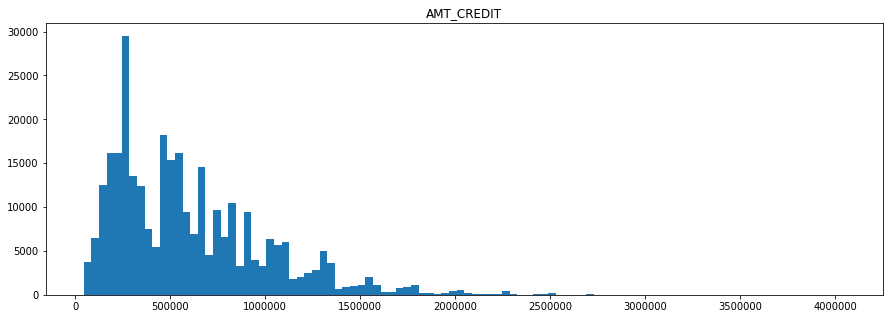

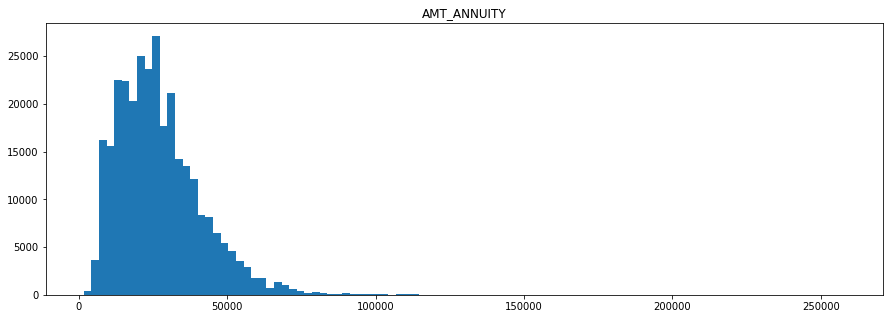

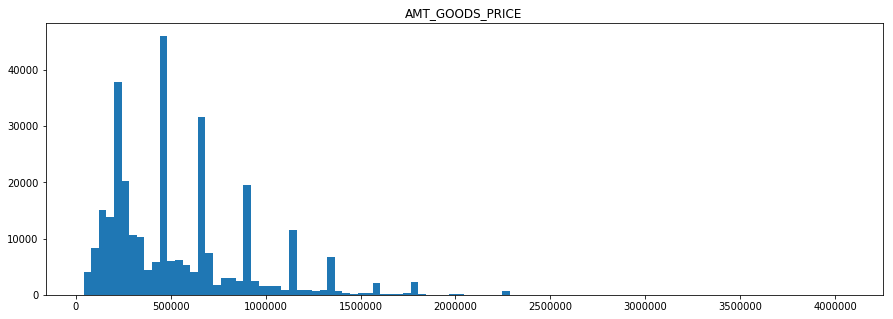

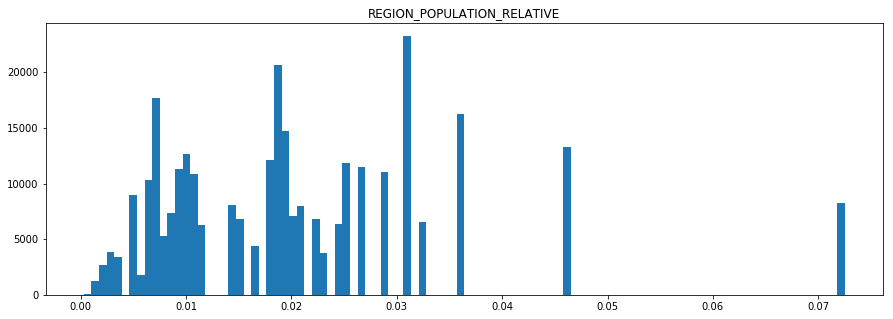

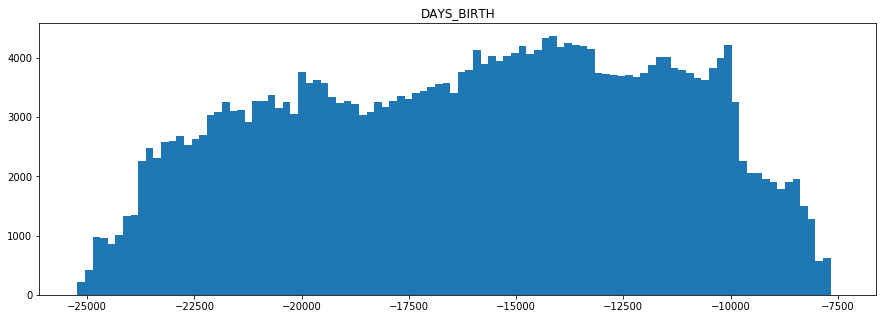

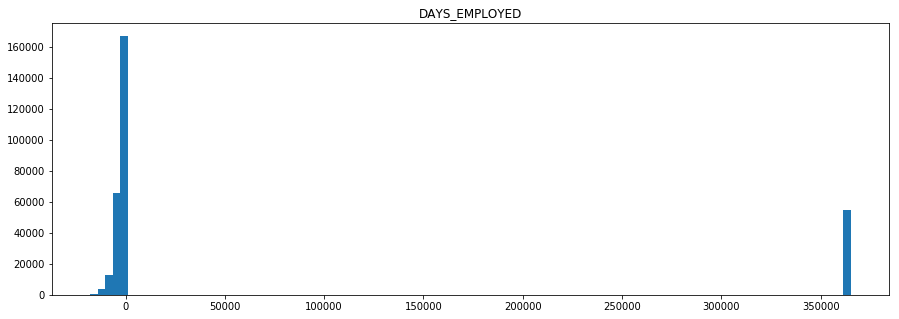

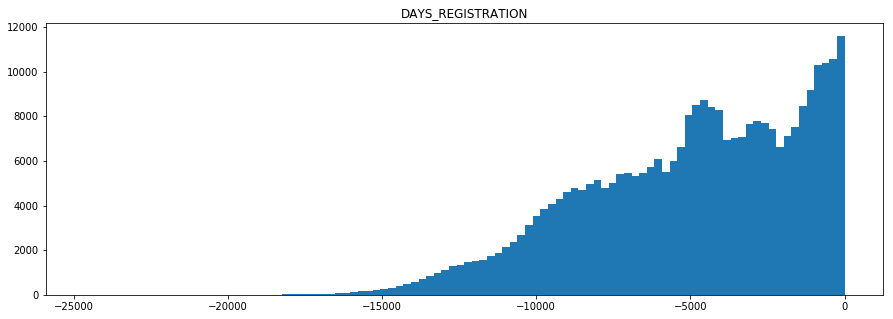

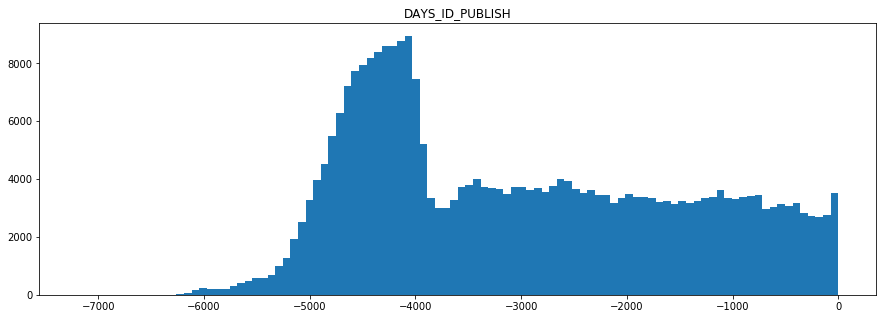

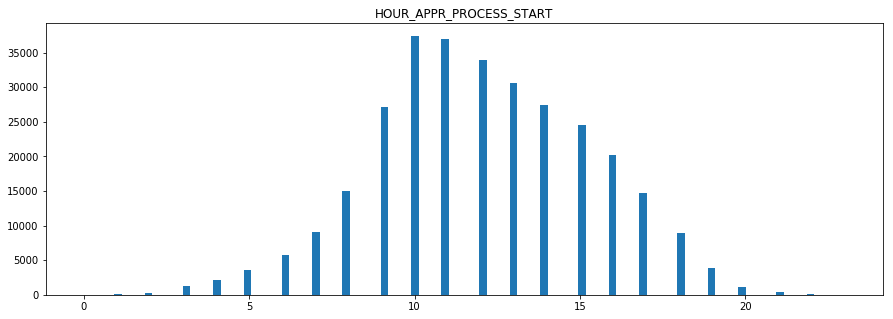

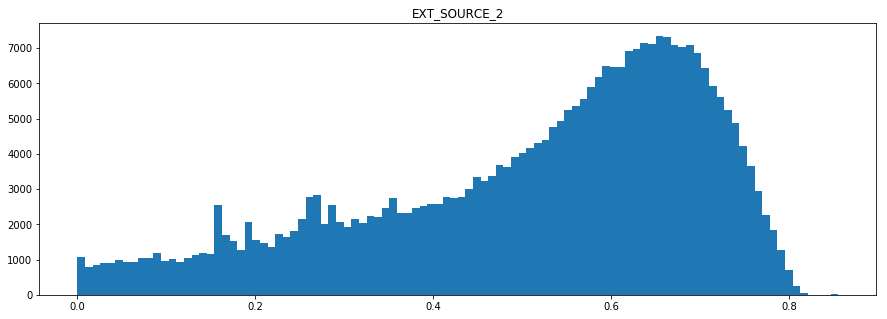

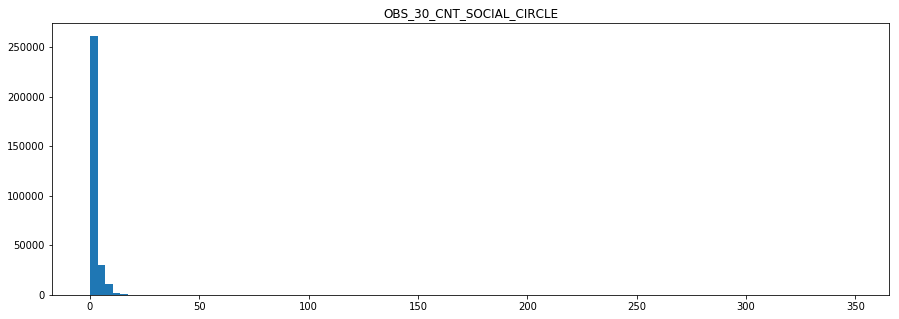

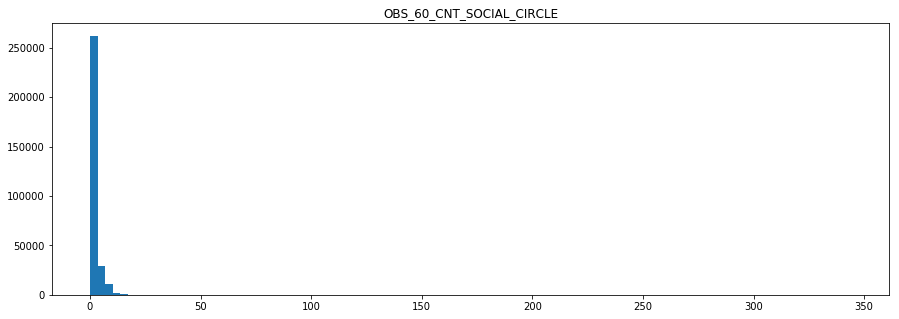

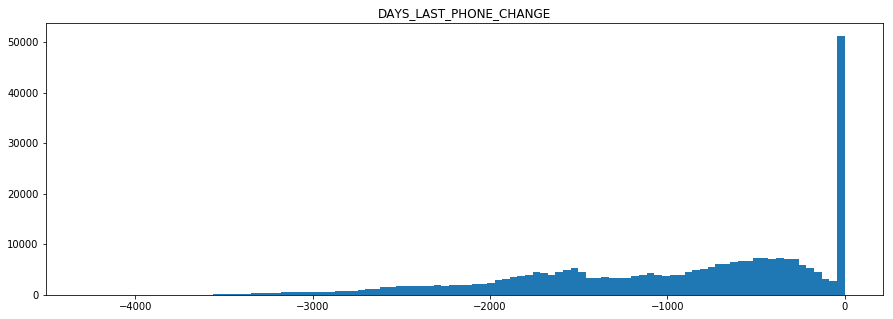

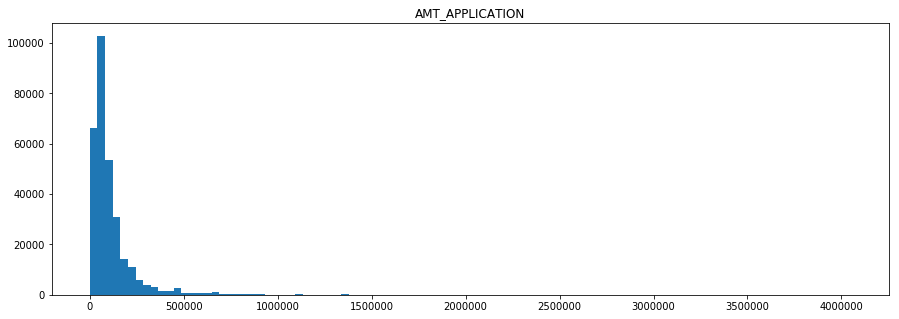

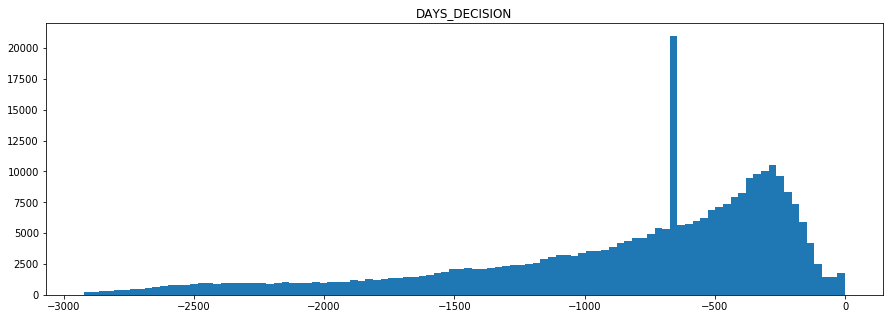

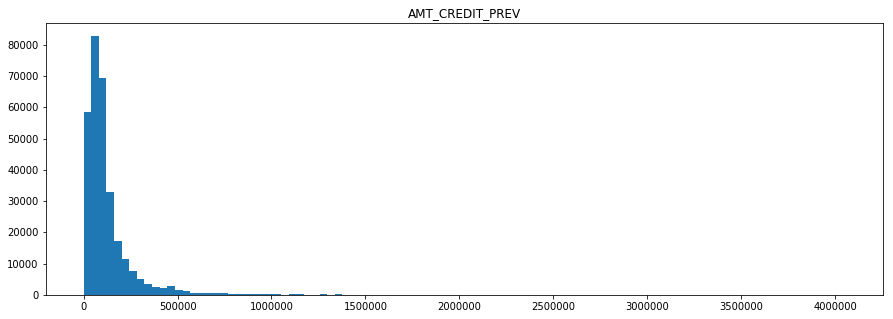

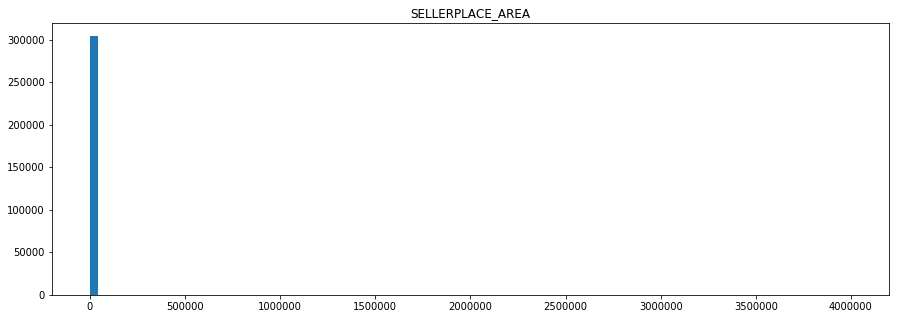

In [45]:
plt.rcParams['figure.figsize'] = [15, 5]

for col in cont_cols:

    plt.hist(df_app[col], bins = 100)
    plt.title(col)
    plt.show()

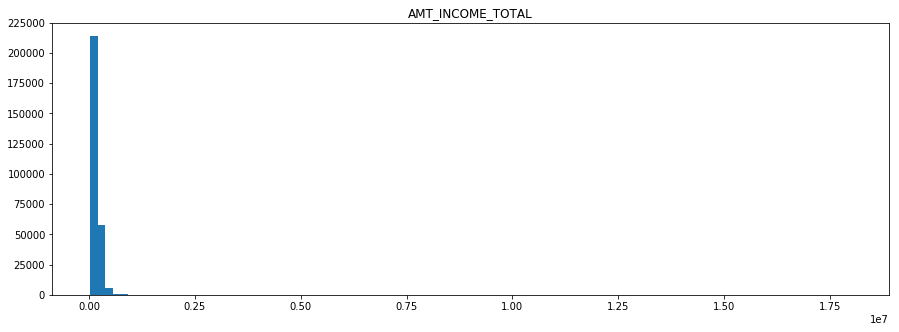

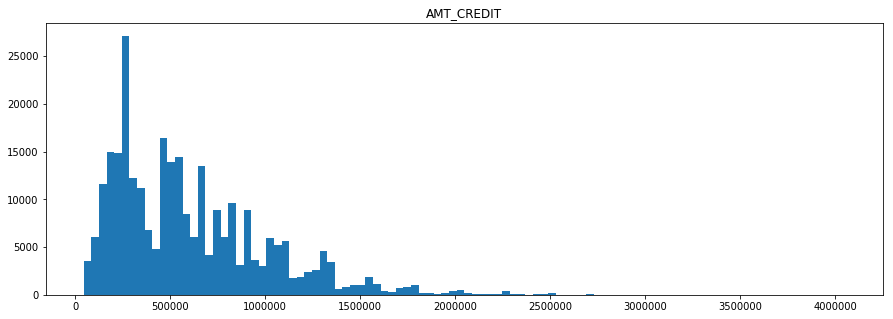

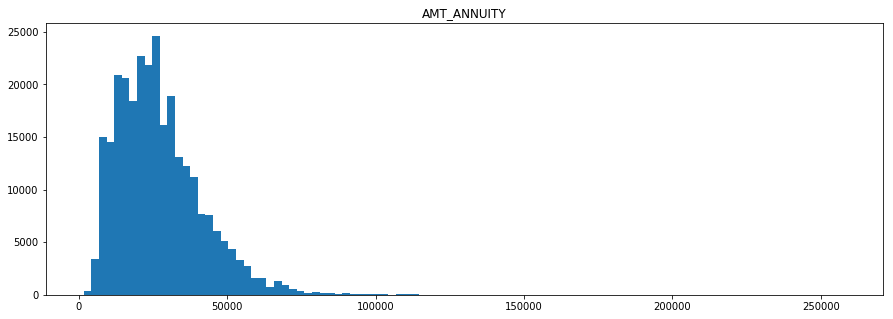

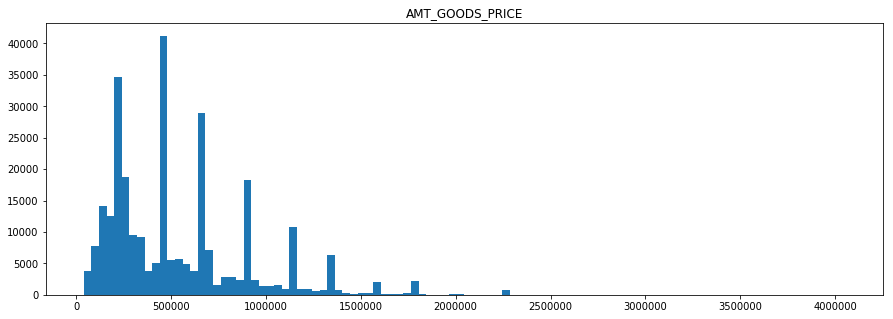

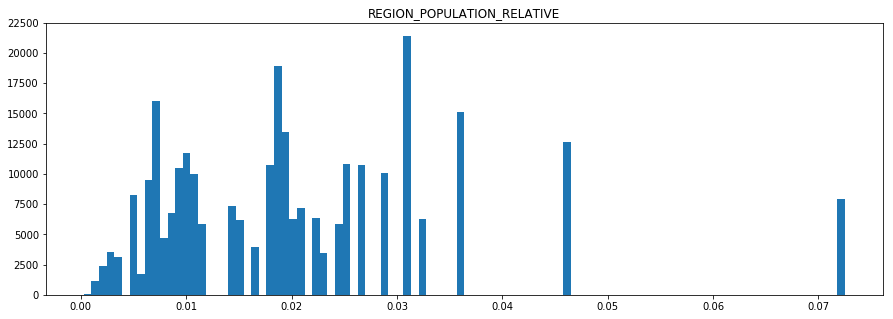

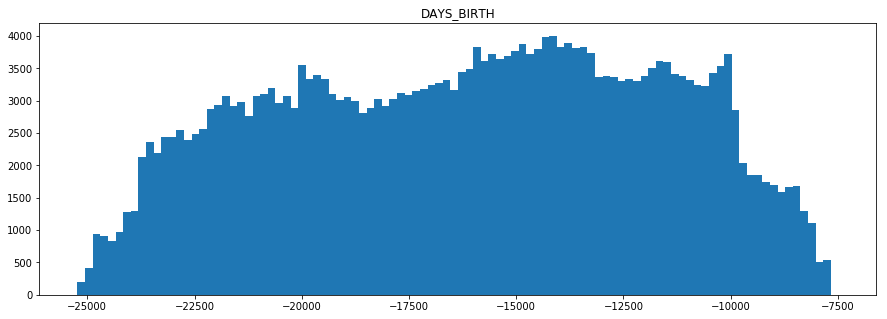

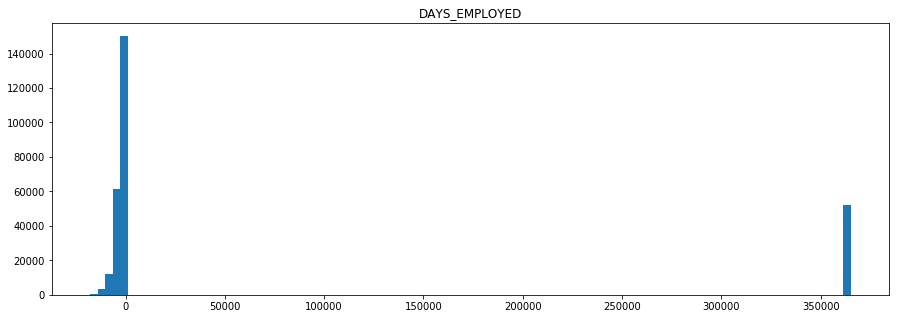

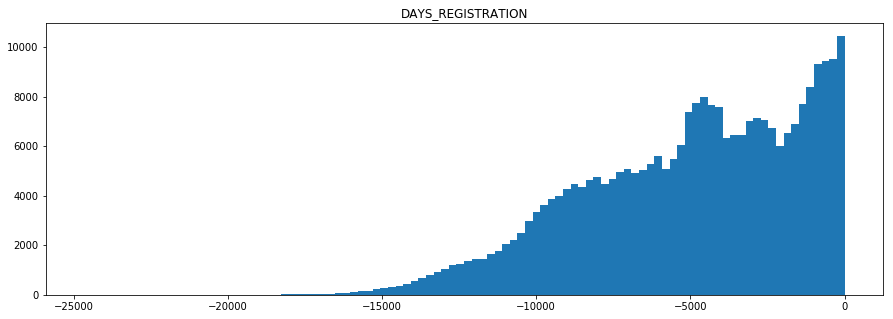

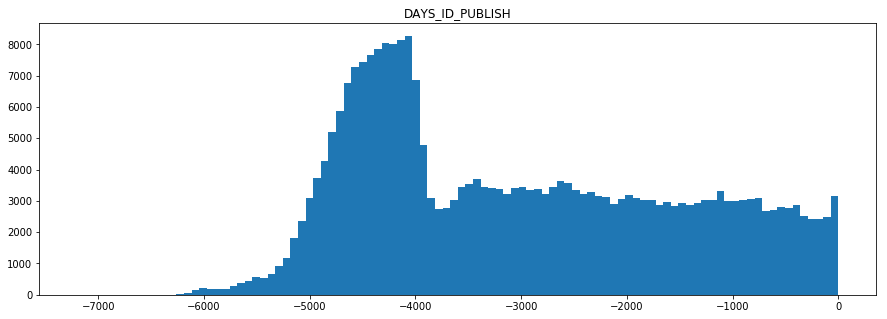

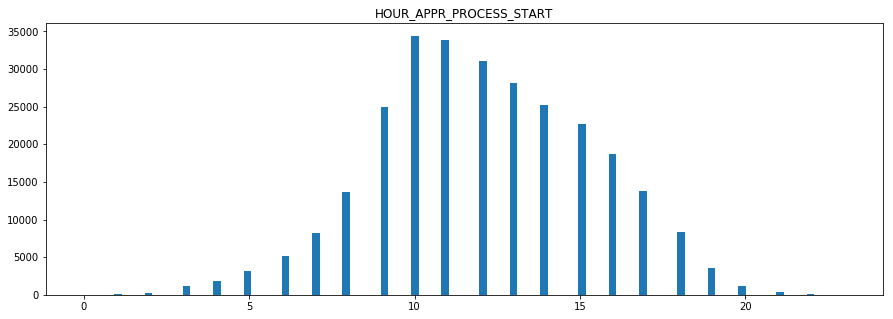

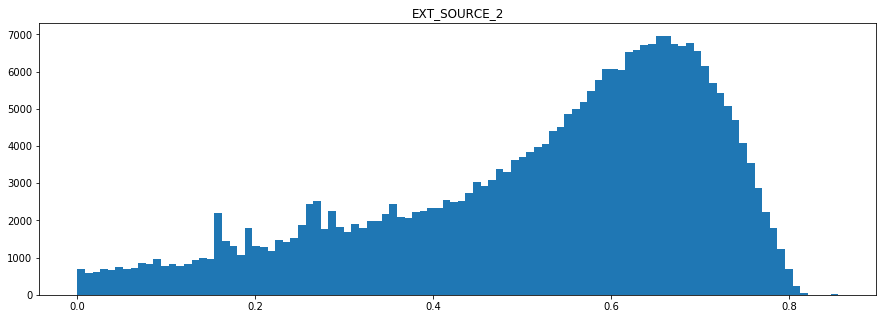

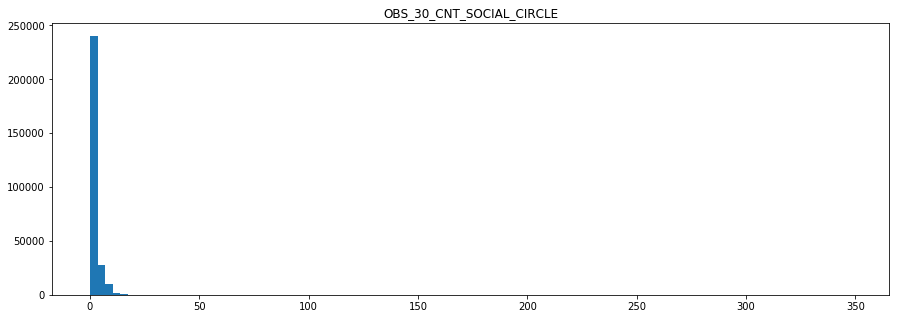

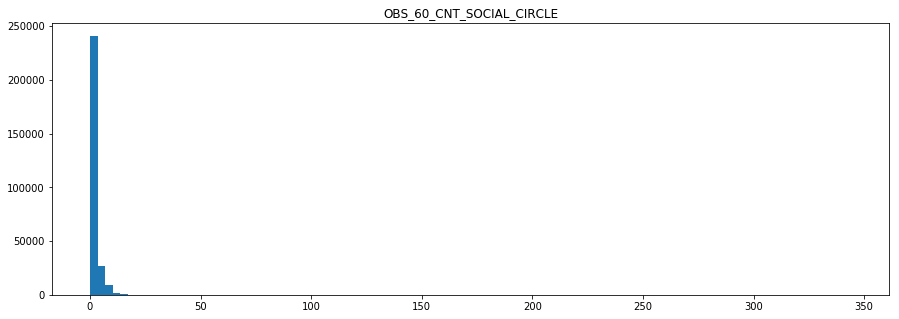

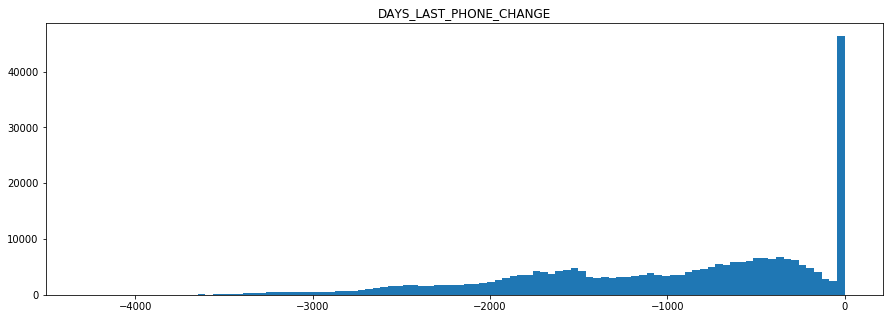

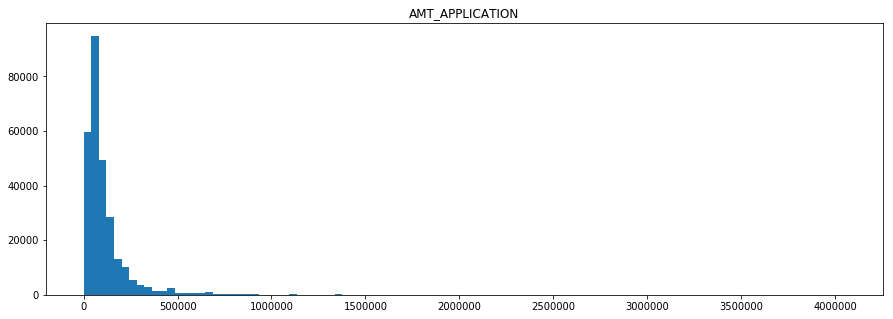

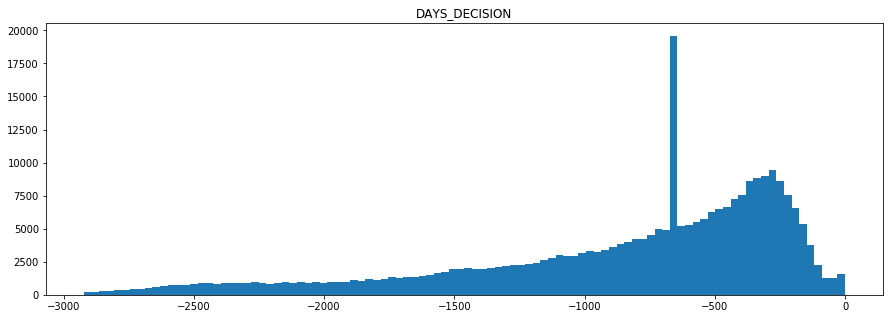

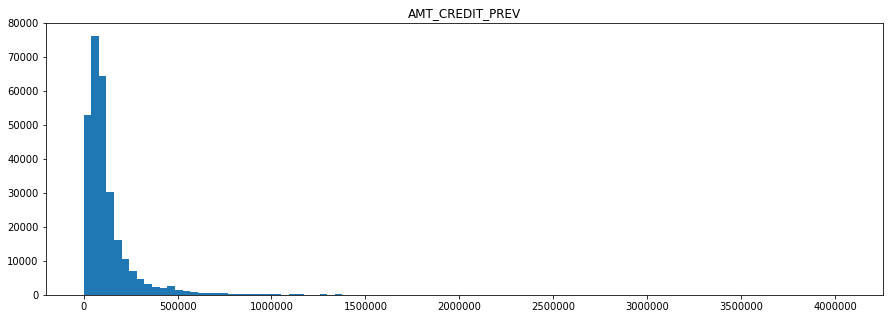

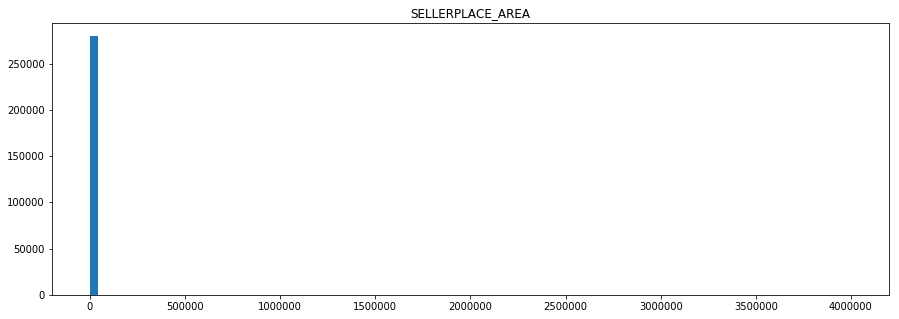

In [46]:
plt.rcParams['figure.figsize'] = [15, 5]

for col in cont_cols:

    plt.hist(df_app[df_app['TARGET']==0][col], bins = 100)
    plt.title(col)
    plt.show()

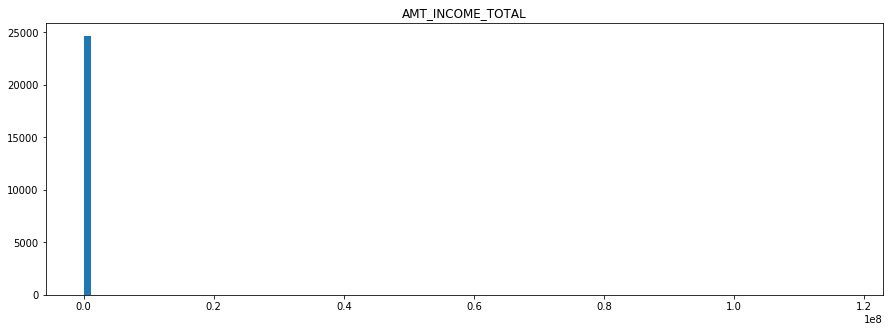

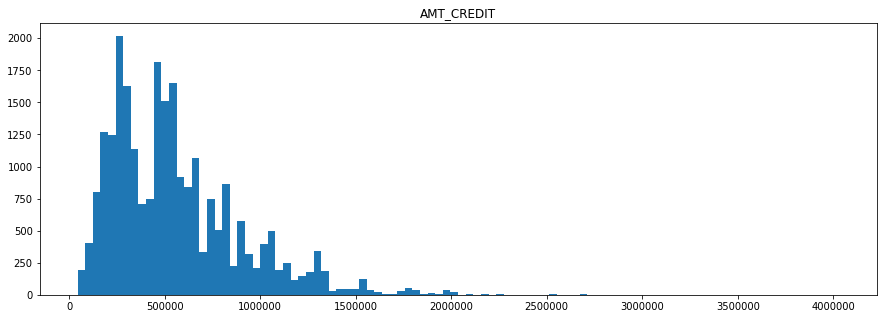

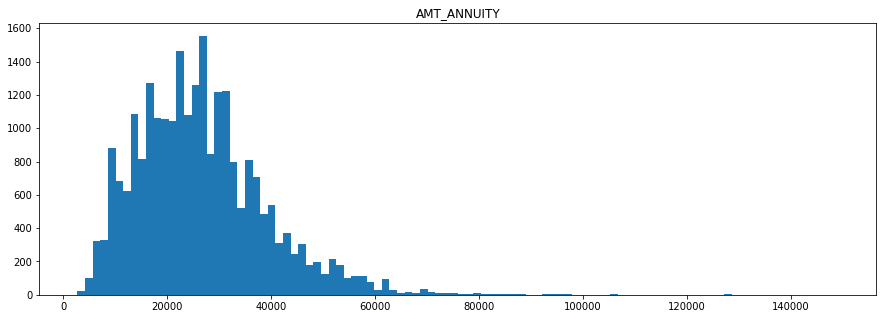

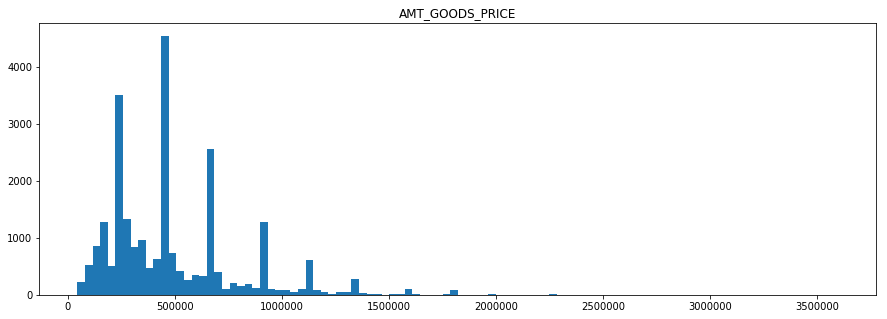

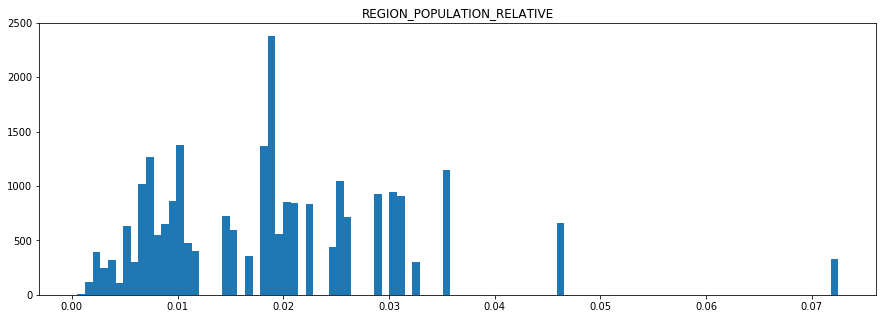

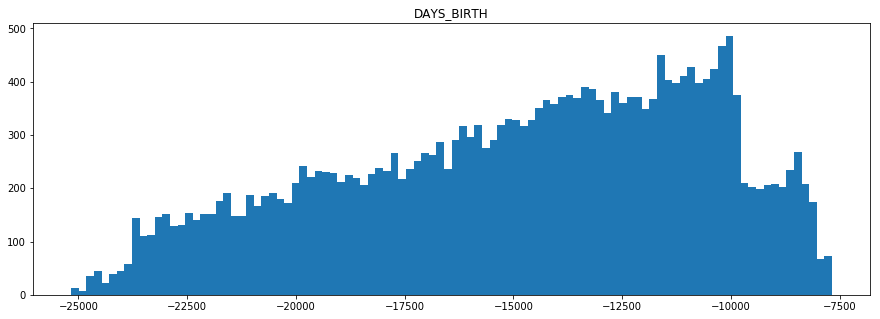

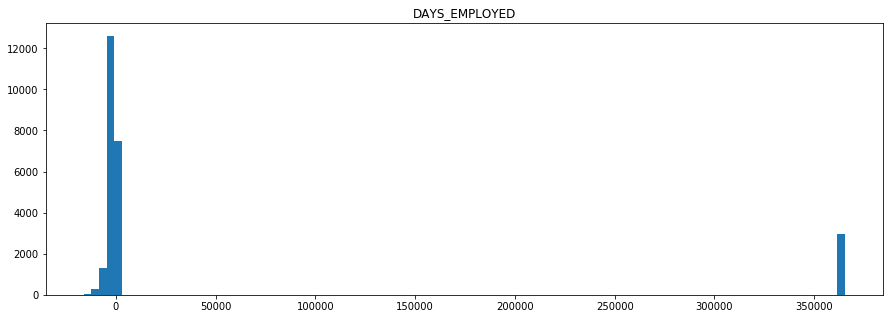

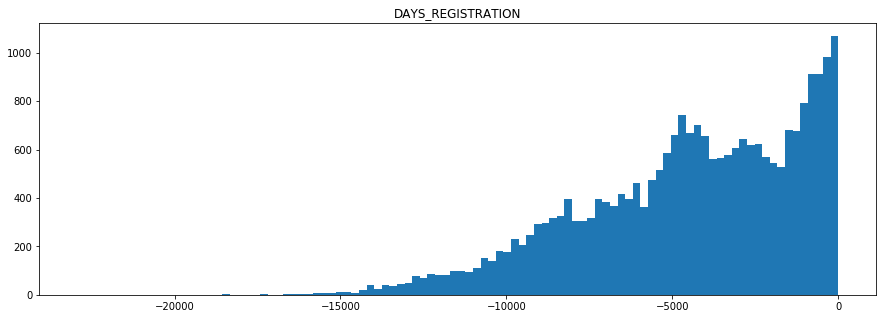

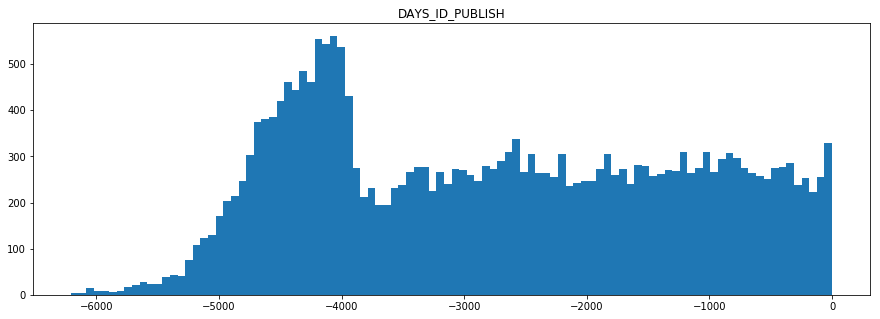

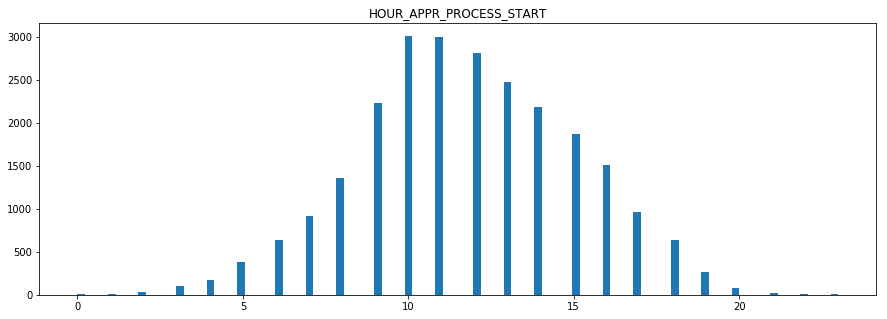

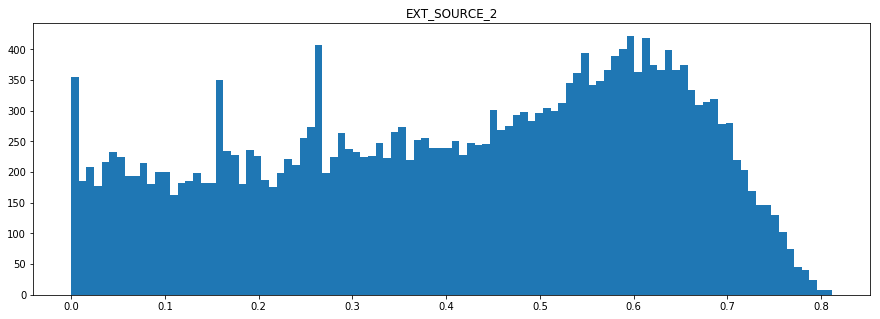

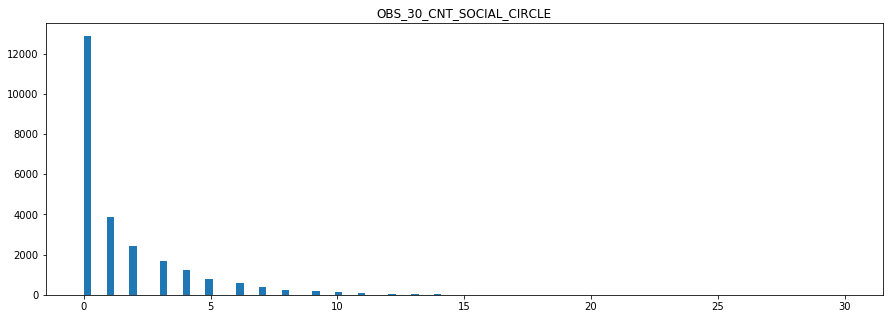

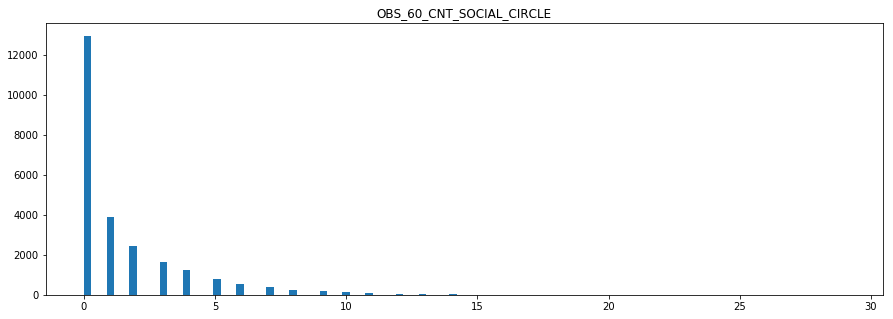

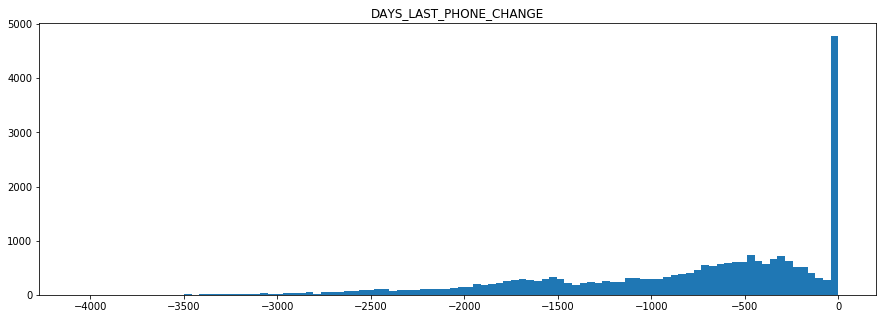

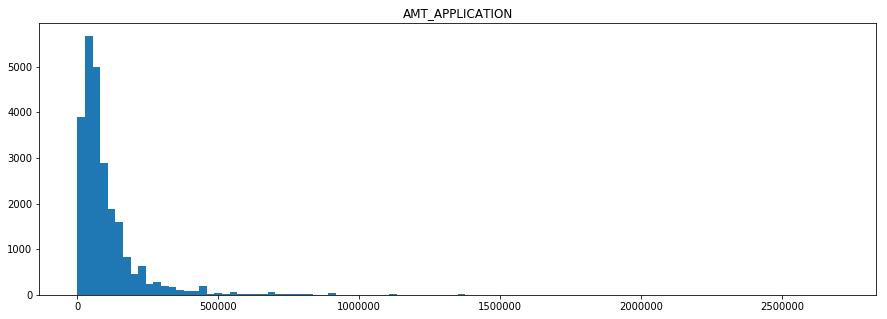

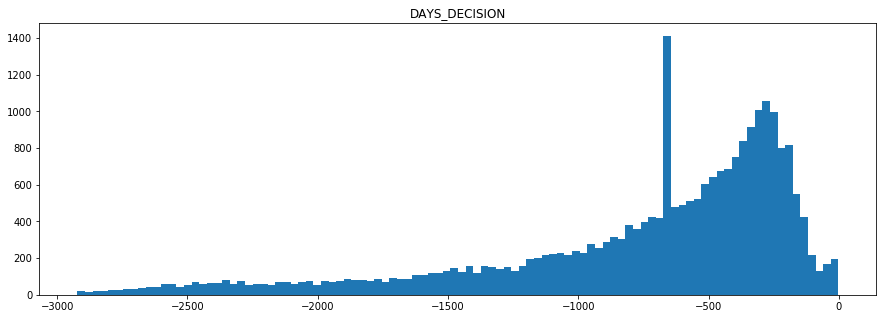

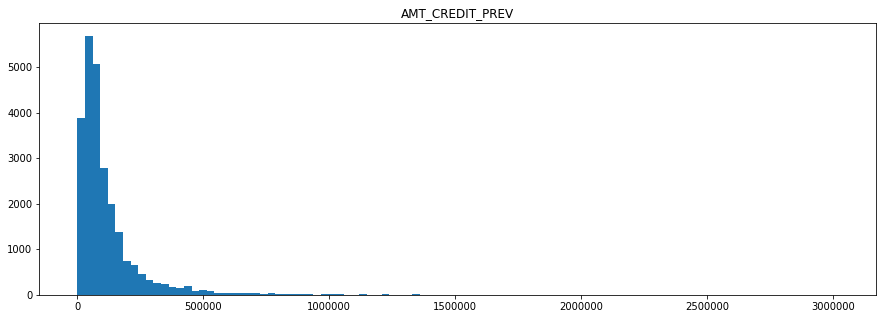

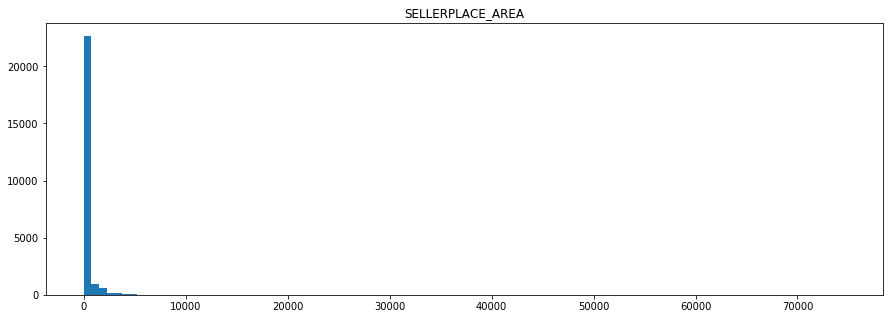

In [47]:
plt.rcParams['figure.figsize'] = [15, 5]

for col in cont_cols:

    plt.hist(df_app[df_app['TARGET']==1][col], bins = 100)
    plt.title(col)
    plt.show()

In [48]:
for col in cont_cols:
    min_outlier = df_app[(np.abs(stats.zscore(df_app[[col]])) >= 3).all(axis=1)]
    
    if min_outlier.shape[0] != 0:
        print(col, min_outlier[col].min(), min_outlier.shape[0])

('AMT_INCOME_TOTAL', 886500.0, 438)
('AMT_CREDIT', 1807420.5, 3196)
('AMT_ANNUITY', 70605.0, 2938)
('AMT_GOODS_PRICE', 1647000.0, 4112)
('REGION_POPULATION_RELATIVE', 0.072508, 8253)
('DAYS_REGISTRATION', -24672.0, 742)
('HOUR_APPR_PROCESS_START', 0, 618)
('OBS_30_CNT_SOCIAL_CIRCLE', 9.0, 6121)
('OBS_60_CNT_SOCIAL_CIRCLE', 9.0, 5946)
('DAYS_LAST_PHONE_CHANGE', -4292.0, 621)
('AMT_APPLICATION', 533250.0, 6028)
('DAYS_DECISION', -2922.0, 1935)
('AMT_CREDIT_PREV', 576069.75, 5955)
('SELLERPLACE_AREA', 32679.5, 101)


In [49]:
keys = set()

for target in [0, 1]:
    corr_obj = defaultdict(list)

    corr_dict = df_app[df_app['TARGET'] == target][cont_cols].corr().to_dict()

    for k,v in corr_dict.items():
        for ck, cv in v.items():

            corr_obj['key'].append(str(sorted((k, ck))))
            corr_obj['value'].append(cv)
            
    print('\nTop 3 correlations for Target: %d'%target)
            
    dfCorr = pd.DataFrame(corr_obj)
    dfCorr = dfCorr.drop_duplicates('value')
    dfCorr['abs_value'] = dfCorr['value'].abs()
    dfCorr = dfCorr[dfCorr['abs_value']!=1].sort_values('abs_value', ascending = False)
    print(dfCorr.iloc[:3][['key', 'value']])
    keys.update(set(dfCorr.iloc[:3]['key'].tolist()))


Top 3 correlations for Target: 0
                                                   key     value
211  ['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIA...  0.998513
176                  ['AMT_CREDIT', 'AMT_GOODS_PRICE']  0.987260
46              ['AMT_APPLICATION', 'AMT_CREDIT_PREV']  0.961263

Top 3 correlations for Target: 1
                                                   key     value
211  ['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIA...  0.998286
176                  ['AMT_CREDIT', 'AMT_GOODS_PRICE']  0.983065
46              ['AMT_APPLICATION', 'AMT_CREDIT_PREV']  0.957095


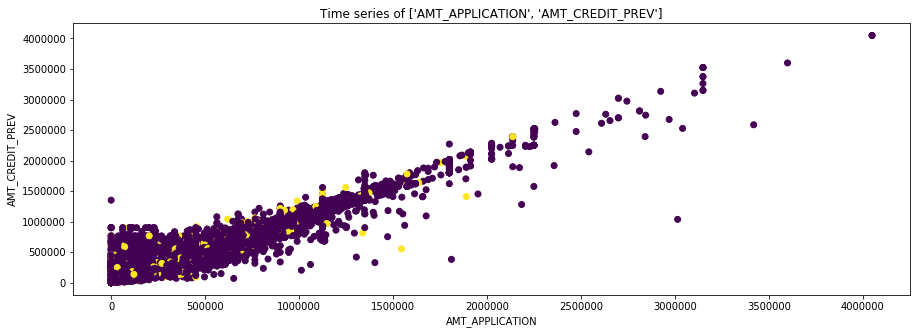

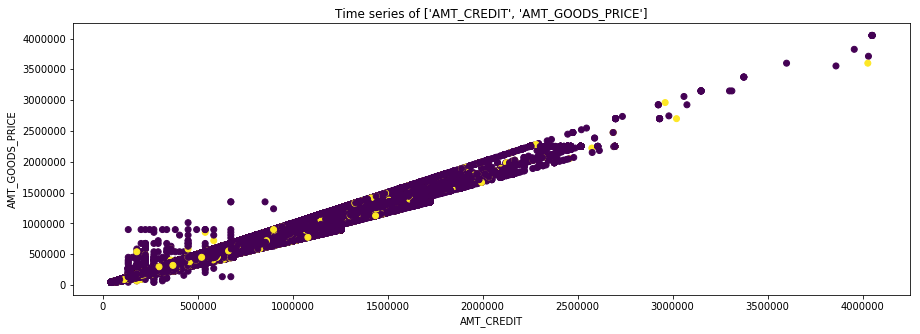

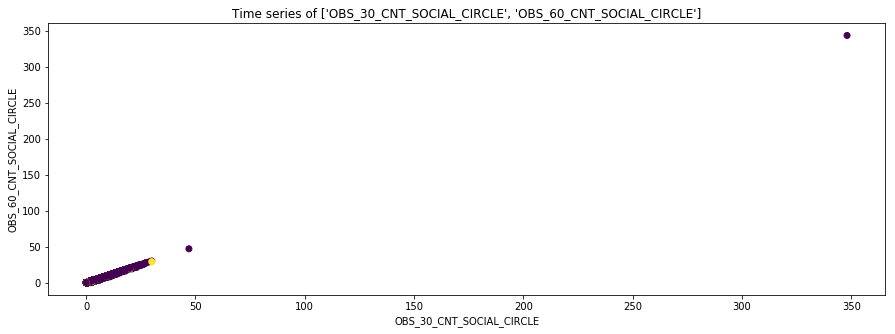

In [50]:
for key in keys:
    attrs = key.replace('[', '').replace(']', '').replace("'", '').split(',')
    attr_0 = attrs[0].strip()
    attr_1 = attrs[1].strip()
    plt.scatter(df_app[attr_0], df_app[attr_1], c = df_app['TARGET'])
    plt.xlabel(attr_0)
    plt.ylabel(attr_1)
    plt.title('Time series of %s'%key)
    plt.show()